In [4]:
## DEPENDENCIES 
!pip install ray
!pip install pyarrow
!pip install tabulate
!pip install opendatasets
!pip install opencv-python
!pip install torchmetrics

  Using cached torchmetrics-0.11.0-py3-none-any.whl (512 kB)


In [1]:
## IMPORT
import opendatasets as od
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import ray
from ray import train
from ray.air import session
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
from ray.data.preprocessors import Concatenator, Chain, StandardScaler
from ray import tune
from ray.tune.tuner import Tuner, TuneConfig
from ray.air.config import RunConfig
from ray.train.batch_predictor import BatchPredictor
from ray.train.torch import TorchPredictor
from ray.data.preprocessor import Preprocessor
from ray.data.aggregate import Max
from ray.data.datasource.partitioning import Partitioning
from ray.data.preprocessors import Concatenator, Chain, StandardScaler
import cv2

from PIL import Image
import os
from torchmetrics import Accuracy

In [2]:
## DATASET DOWNLOAD
od.download(
    "https://www.kaggle.com/datasets/wwymak/architecture-dataset")

Skipping, found downloaded files in ".\architecture-dataset" (use force=True to force download)


In [3]:
## DATASET LOADING

HEIGHT = 224
WIDTH = 224

root = "architecture-dataset/architecture-dataset/arcDataset/"
partitioning = Partitioning("dir", field_names=["class"], base_dir=root)
dataset = ray.data.read_images(root, partitioning=partitioning, size=(HEIGHT, WIDTH), mode="RGB")
train_dataset, validation_dataset = dataset.train_test_split(test_size=0.05)

2023-01-06 16:12:24,656	INFO worker.py:1538 -- Started a local Ray instance.
Read progress: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2406.43it/s]


In [4]:
## EXEMPLARY ELEMENT FROM THE DATASET

In [5]:
## PREPROCESSING

CLASS_ID_MAPPING = {'Achaemenid architecture': 0,
                    'American Foursquare architecture': 1, 
                    'American craftsman style': 2, 
                    'Ancient Egyptian architecture': 3, 
                    'Art Deco architecture': 4,
                    'Art Nouveau architecture': 5,
                    'Baroque architecture': 6,
                    'Bauhaus architecture': 7,
                    'Beaux-Arts architecture': 8,
                    'Byzantine architecture': 9,
                    'Chicago school architecture': 10,
                    'Colonial architecture': 11,
                    'Deconstructivism': 12,
                    'Edwardian architecture': 13,
                    'Georgian architecture': 14,
                    'Gothic architecture': 15,
                    'Greek Revival architecture': 16,
                    'International style': 17,
                    'Novelty architecture': 18,
                    'Palladian architecture': 19, 
                    'Postmodern architecture': 20,
                    'Queen Anne architecture': 21, 
                    'Romanesque architecture': 22, 
                    'Russian Revival architecture': 23, 
                    'Tudor Revival architecture': 24}

ID_CLASS_MAPPING = {value: key for key, value in CLASS_ID_MAPPING.items()}

NUMBER_OF_CLASSES = len(CLASS_ID_MAPPING)

class OpenCVPreprocessor(Preprocessor):
    def _fit(self, dataset):
        self.stats_ = None
    
    def _transform_numpy(self, df):
        images = df["image"]
        result = []
        for image in images:
            #image = cv2.Canny(image=image, threshold1=100, threshold2=2000) 
            image = cv2.resize(image, (HEIGHT,WIDTH), interpolation=cv2.INTER_CUBIC)
            result.append(np.transpose(image, (2, 0, 1)))
        result = np.array(result)
        df["image"] = result
        
        classes = df["class"]
        result = []
        for class_name in classes:
            result.append(CLASS_ID_MAPPING[class_name])
        result = np.array(result)
        df["class"] = result
        return df
    


Map_Batches: 100%|████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 123.60it/s]

CLASS: Russian Revival architecture


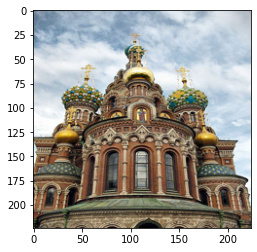

In [12]:
## EXEMPLARY ELEMENT FROM THE DATASET AFTER THE PREPROCESSING
transformed_validation_dataset = OpenCVPreprocessor().fit_transform(validation_dataset)
element = next(transformed_validation_dataset.iter_torch_batches(batch_size=1))

import matplotlib.pyplot as plt
print(f"CLASS: {ID_CLASS_MAPPING[element['class'].item()]}")
image = np.transpose(element["image"][0], (1, 2, 0))
plt.imshow(image)

In [7]:
## ResNet34 definition

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [16]:
# TRAINING
VALIDATION_DATASET_COUNT = validation_dataset.count()
def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["num_epochs"]
    number_of_classes = config["number_of_classes"]

    train_data = session.get_dataset_shard("train")
    validation_data = session.get_dataset_shard("validation")
    model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=number_of_classes)
    model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)
    
    for cur_epoch in range(epochs):
        batch_number = 0
        for batch in train_data.iter_torch_batches(batch_size=batch_size, dtypes=torch.float32, local_shuffle_buffer_size=batch_size):
            print(f"{cur_epoch}/{batch_number}:{batch['class']}")
            inputs, labels = batch["image"], batch["class"]
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, labels.type(torch.LongTensor))
            train_loss.backward()
            optimizer.step()
            batch_number += 1
        loss = train_loss.item()
        print(f"RANK: {session.get_world_rank()} {cur_epoch}/{batch_number} - LOSS: {loss}")
        session.report({"loss": loss}, checkpoint=TorchCheckpoint.from_model(model))
        print("END OF EPOCH")
        
#         if session.get_world_rank() == 0:
#             validation_batch = next(validation_data.iter_torch_batches(batch_size=10, dtypes=torch.float32))
#             accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES)
#             predictions = model(validation_batch["image"])
#             accuracy = accuracy(predictions, validation_batch["class"]).numpy()
#             print(f"RANK: {session.get_world_rank()} EPOCH: {cur_epoch} ACCURACY: {accuracy}")
#             session.report({"accuracy": accuracy}, checkpoint=TorchCheckpoint.from_model(model))

preprocessor = OpenCVPreprocessor()

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 32,
        "num_epochs": 20,
        "lr": 0.01,
        "number_of_classes": NUMBER_OF_CLASSES
    },
    scaling_config=ScalingConfig(
        num_workers=10, 
        use_gpu=False
    ),
    datasets={"train": train_dataset, "validation": validation_dataset},
    preprocessor= preprocessor,
)

result = trainer.fit()
print(f"Last result: {result.metrics}")

2023-01-06 18:37:00,455	INFO data_parallel_trainer.py:286 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2023-01-06 18:37:00,496	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(TorchTrainer pid=10832) 2023-01-06 18:37:05,628	INFO data_parallel_trainer.py:286 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(RayTrainWorker pid=38448) 2023-01-06 18:37:19,254	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=10]
(RayTrainWorker pid=38448) 2023-01-06 18:37:24,102	INFO train_loop_utils.py:270 -- Moving model to device: cpu
(RayTrainWorker pid=38448) 2023-01-06 18:37:24,105	INFO train_loop_utils.py:330 -- Wrapping provided model in DistributedDataParallel.


(RayTrainWorker pid=16212) 0/0:tensor([ 6.,  6., 10., 12., 12.,  6., 10.,  9., 10., 12., 12., 11.,  6.,  9.,
(RayTrainWorker pid=16212)          6.,  6., 12., 10., 10.,  6., 12., 12.,  6.,  6.,  6., 10.,  6.,  9.,
(RayTrainWorker pid=16212)          5.,  6., 12., 12.])
(RayTrainWorker pid=15776) 0/0:tensor([ 3., 19., 10., 19., 10., 19., 10., 10.,  3.,  3., 19., 10.,  3., 19.,
(RayTrainWorker pid=15776)         10., 10.,  3., 19., 19., 10., 19.,  3., 10., 10., 10., 19., 19., 19.,
(RayTrainWorker pid=15776)         10.,  3.,  3., 10.])
(RayTrainWorker pid=7180) 0/0:tensor([12., 15., 21., 21., 12., 12., 15., 21., 21., 15., 21., 21., 15., 15.,
(RayTrainWorker pid=7180)         21., 12., 12., 12., 15., 21., 15., 12., 21., 21., 12., 15., 21., 15.,
(RayTrainWorker pid=7180)         12., 21., 12., 12.])
(RayTrainWorker pid=38448) 0/0:tensor([14., 11., 14., 14., 11., 16., 16., 14., 11., 14., 16., 14., 11., 11.,
(RayTrainWorker pid=38448)         11., 11., 16., 14., 16., 16., 11., 14., 14., 14.,

(RayTrainWorker pid=21592) 0/3:tensor([ 5.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5., 18., 18.,  5.,
(RayTrainWorker pid=21592)          5., 19.,  5., 16.,  4.,  4.,  5.,  3., 16., 19., 16., 16.,  5., 16.,
(RayTrainWorker pid=21592)          5., 19.,  4., 16.])
(RayTrainWorker pid=14392) 0/3:tensor([18.,  5.,  5.,  5.,  5., 18.,  6.,  6.,  0., 18.,  5.,  5.,  5., 18.,
(RayTrainWorker pid=14392)          0.,  6.,  6.,  5.,  5.,  5., 18.,  5.,  5., 19.,  5., 18.,  6., 18.,
(RayTrainWorker pid=14392)         18.,  6., 18.,  6.])
(RayTrainWorker pid=32944) 0/3:tensor([ 2.,  5.,  8.,  8.,  8.,  2., 16.,  2.,  8.,  5.,  2., 16.,  2.,  5.,
(RayTrainWorker pid=32944)          5.,  5.,  8.,  8.,  3.,  2.,  2.,  2.,  8.,  2.,  2., 16.,  5.,  2.,
(RayTrainWorker pid=32944)          8.,  3.,  8., 16.])
(RayTrainWorker pid=31432) 0/3:tensor([21.,  8.,  9., 21.,  9.,  8., 12., 21.,  8., 20.,  9., 20.,  4.,  4.,
(RayTrainWorker pid=31432)          4., 21.,  8.,  4., 21.,  4.,  4.,  8.,  8.,  

(RayTrainWorker pid=21592) 0/6:tensor([12., 12., 11.,  8.,  8.,  5., 12.,  8., 11., 11., 19.,  8., 11., 19.,
(RayTrainWorker pid=21592)         12., 11., 11., 18.,  4., 12., 11.,  5.,  8.,  8.,  4., 11., 11., 19.,
(RayTrainWorker pid=21592)         12., 12.,  3., 11.])
(RayTrainWorker pid=14392) 0/6:tensor([20., 21., 20.,  5., 20., 20., 18., 18.,  5., 20., 18., 20.,  5.,  5.,
(RayTrainWorker pid=14392)         21.,  5., 21., 20., 20.,  5., 20., 21., 18., 18.,  6., 18., 21., 20.,
(RayTrainWorker pid=14392)         18.,  6., 18., 20.])
(RayTrainWorker pid=32944) 0/6:tensor([22.,  2.,  8.,  2., 21., 22.,  5.,  4.,  4., 22., 20., 22.,  1.,  4.,
(RayTrainWorker pid=32944)          2., 22., 22., 22.,  2.,  4.,  5.,  4.,  2., 22.,  2., 22.,  2.,  4.,
(RayTrainWorker pid=32944)         22., 20.,  4.,  8.])
(RayTrainWorker pid=31432) 0/6:tensor([23., 23.,  8.,  4.,  4., 21., 12., 23.,  4., 12.,  4.,  4., 23., 21.,
(RayTrainWorker pid=31432)         12., 12., 12.,  4., 23., 21.,  9., 12., 12., 1

(RayTrainWorker pid=21592) 0/9:tensor([10., 12., 10.,  5., 10., 12., 10., 12., 19., 12., 12., 10., 12., 16.,
(RayTrainWorker pid=21592)          5.,  5.,  5.,  5., 11.,  8., 12., 12., 10.,  5., 19.,  5.,  5.,  5.,
(RayTrainWorker pid=21592)         11., 10., 12.,  5.])
(RayTrainWorker pid=14392) 0/9:tensor([ 9.,  2., 20., 21., 23.,  2.,  9., 18., 21., 13., 13.,  9., 23., 21.,
(RayTrainWorker pid=14392)         23.,  2., 21., 23., 20.,  9.,  5., 23.,  2.,  9.,  2.,  2.,  2., 23.,
(RayTrainWorker pid=14392)         13., 23., 23., 23.])
(RayTrainWorker pid=32944) 0/9:tensor([16.,  2., 16., 21., 17., 17., 16., 16., 17., 17., 17., 17., 16., 16.,
(RayTrainWorker pid=32944)          8., 16.,  8., 21., 16., 17., 16., 21., 16., 21., 16., 17., 16., 20.,
(RayTrainWorker pid=32944)          8., 17., 21., 16.])
(RayTrainWorker pid=31432) 0/9:tensor([ 4.,  4.,  4.,  4., 20., 21.,  7.,  4.,  4., 20.,  8.,  4.,  4.,  4.,
(RayTrainWorker pid=31432)          4.,  4., 20.,  4., 20.,  4.,  4., 20.,  4.,  

(RayTrainWorker pid=21592) 0/12:tensor([10., 14.,  6.,  6., 14.,  6.,  6.,  5., 21., 21.,  6.,  6., 10.,  5.,
(RayTrainWorker pid=21592)          6., 10.,  5., 21., 21., 14., 14., 10.,  6.,  6., 10., 21., 11., 14.,
(RayTrainWorker pid=21592)         21.,  6.,  6.,  6.])
(RayTrainWorker pid=14392) 0/12:tensor([11., 11.,  3.,  4., 11.,  9.,  4.,  4., 18.,  4.,  3., 18.,  4., 11.,
(RayTrainWorker pid=14392)          4., 18.,  4.,  4.,  4., 11.,  4., 11., 18.,  4.,  9.,  3.,  3., 18.,
(RayTrainWorker pid=14392)         18.,  4., 11.,  3.])
(RayTrainWorker pid=32944) 0/12:tensor([ 6., 17., 17.,  6., 16.,  6.,  5.,  6.,  6., 17., 16., 16.,  6., 17.,
(RayTrainWorker pid=32944)          6.,  6., 16., 11., 11., 17.,  6., 16., 16., 17., 17.,  6., 11.,  8.,
(RayTrainWorker pid=32944)          6., 17.,  6.,  8.])
(RayTrainWorker pid=31432) 0/12:tensor([22.,  3.,  8., 14., 14.,  3., 22., 22.,  4.,  3., 14.,  3., 22.,  8.,
(RayTrainWorker pid=31432)          3.,  8.,  4., 21.,  4.,  8., 14., 21.,  8

Trial name,_time_this_iter_s,_timestamp,_training_iteration,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TorchTrainer_b9a62_00000,361.2,1673036078,20,2023-01-06_21-14-39,True,,64f5d697dae1431e9241b1bb8ea701e8,0,LAPTOP-S8FJSVCO,20,2.26824,127.0.0.1,10832,True,9453.66,361.196,9453.66,1673036079,0,,20,b9a62_00000,0.0798683


(RayTrainWorker pid=21592) END OF EPOCH
(RayTrainWorker pid=21592) 1/0:tensor([ 4., 18.,  4., 18., 18.,  5., 18., 18.,  3.,  3., 18.,  5.,  3.,  4.,
(RayTrainWorker pid=21592)          5., 18.,  5., 18.,  3.,  5., 18., 18., 18.,  3.,  3.,  5., 18.,  4.,
(RayTrainWorker pid=21592)          3.,  5.,  3., 18.])
(RayTrainWorker pid=14392) END OF EPOCH
(RayTrainWorker pid=14392) 1/0:tensor([18., 18., 18.,  5., 18., 18., 18.,  5., 18.,  5., 18., 18., 18.,  5.,
(RayTrainWorker pid=14392)         18., 18., 18., 19., 19.,  5.,  5., 18.,  5.,  5., 19., 19., 19.,  5.,
(RayTrainWorker pid=14392)         18., 18.,  5., 18.])
(RayTrainWorker pid=32944) END OF EPOCH
(RayTrainWorker pid=32944) 1/0:tensor([2., 2., 3., 0., 3., 2., 0., 0., 2., 0., 0., 3., 0., 2., 3., 0., 0., 3.,
(RayTrainWorker pid=32944)         3., 3., 2., 2., 3., 0., 3., 3., 0., 0., 3., 0., 0., 0.])
(RayTrainWorker pid=31432) END OF EPOCH
(RayTrainWorker pid=31432) 1/0:tensor([21., 12., 21., 20., 21., 12., 21., 12., 12., 20., 21., 20.

(RayTrainWorker pid=21592) 1/3:tensor([19., 16.,  3.,  4.,  4.,  5.,  3.,  5.,  5.,  5.,  3., 19.,  5., 19.,
(RayTrainWorker pid=21592)          4.,  4., 16.,  5., 16., 18., 16., 16.,  5.,  5., 16.,  5.,  4.,  5.,
(RayTrainWorker pid=21592)         19., 18.,  4.,  5.])
(RayTrainWorker pid=14392) 1/3:tensor([19., 19.,  6.,  6.,  5.,  5., 18., 18.,  6.,  5.,  5.,  5.,  6.,  5.,
(RayTrainWorker pid=14392)         18., 18., 18.,  5.,  0., 18.,  5.,  5., 18.,  5.,  0.,  5.,  0.,  5.,
(RayTrainWorker pid=14392)          0.,  5., 18., 18.])
(RayTrainWorker pid=32944) 1/3:tensor([ 2.,  8., 16.,  8.,  2.,  8.,  2.,  5.,  5.,  2., 16.,  5.,  8.,  8.,
(RayTrainWorker pid=32944)          3.,  5.,  2.,  8.,  2.,  5.,  2., 16., 16.,  3.,  2., 16.,  8.,  2.,
(RayTrainWorker pid=32944)          8.,  8.,  5.,  8.])
(RayTrainWorker pid=31432) 1/3:tensor([21.,  8.,  9.,  8.,  9.,  4.,  8.,  8.,  8., 21.,  8.,  4., 12., 21.,
(RayTrainWorker pid=31432)          9.,  9.,  4., 21.,  8.,  8.,  4.,  8., 21.,  

(RayTrainWorker pid=21592) 1/6:tensor([12., 11.,  5., 11.,  8., 12., 12.,  8.,  4., 12., 11., 12.,  8., 11.,
(RayTrainWorker pid=21592)         19., 16., 11.,  8.,  8.,  8., 11.,  3., 19., 11., 12.,  5., 11., 11.,
(RayTrainWorker pid=21592)         11.,  4., 11., 11.])
(RayTrainWorker pid=14392) 1/6:tensor([20., 18., 21., 18., 20., 18., 21., 20.,  5., 21., 18.,  5., 20.,  5.,
(RayTrainWorker pid=14392)         20., 20., 20., 18., 20., 20., 20., 20., 20., 20., 21.,  5., 20., 19.,
(RayTrainWorker pid=14392)         21.,  5., 20., 18.])
(RayTrainWorker pid=32944) 1/6:tensor([22.,  4.,  4., 22.,  4.,  4.,  4.,  4., 22.,  2.,  4.,  2., 22.,  4.,
(RayTrainWorker pid=32944)         22., 22., 22., 22., 22., 20., 22., 16.,  4.,  1., 20.,  4., 20., 22.,
(RayTrainWorker pid=32944)          2., 20.,  8., 22.])
(RayTrainWorker pid=31432) 1/6:tensor([12., 12., 12., 23., 23.,  4., 20., 21., 12., 23.,  4., 12., 21., 21.,
(RayTrainWorker pid=31432)         12.,  4., 21.,  4., 12., 12.,  4., 12., 12.,  

(RayTrainWorker pid=21592) 1/9:tensor([12., 12., 10.,  5., 10., 10., 12., 10., 12.,  5.,  5.,  5.,  5., 12.,
(RayTrainWorker pid=21592)         10.,  5.,  5., 10., 12., 10.,  5.,  5.,  5., 12., 10., 12.,  5., 10.,
(RayTrainWorker pid=21592)         12., 10., 12., 10.])
(RayTrainWorker pid=14392) 1/9:tensor([18.,  5., 23.,  9.,  9.,  9.,  9., 13., 23.,  2., 23.,  9., 21., 13.,
(RayTrainWorker pid=14392)          2., 23., 21., 23., 23.,  2., 23., 23., 23., 18., 18.,  2., 23., 23.,
(RayTrainWorker pid=14392)         18.,  9., 13., 20.])
(RayTrainWorker pid=32944) 1/9:tensor([16., 17., 16., 22.,  8., 17., 22., 16., 17., 17., 16., 22., 21., 17.,
(RayTrainWorker pid=32944)          4.,  8., 17., 17., 17.,  8., 16.,  8., 16.,  8., 16., 22., 16., 17.,
(RayTrainWorker pid=32944)         16., 21.,  8., 17.])
(RayTrainWorker pid=31432) 1/9:tensor([ 7.,  4., 12.,  4.,  4.,  4.,  7.,  4.,  4.,  4.,  4.,  7.,  4.,  4.,
(RayTrainWorker pid=31432)         20.,  4., 20.,  4.,  7.,  4., 12.,  4., 20., 1

(RayTrainWorker pid=31432) 1/12:tensor([14., 22.,  4., 14., 21., 12., 22.,  3., 22., 14.,  3., 22., 21., 22.,
(RayTrainWorker pid=31432)          3.,  4., 22., 20., 22.,  8., 14., 21., 14.,  3.,  4.,  4., 22., 14.,
(RayTrainWorker pid=31432)         14., 20.,  3., 21.])
(RayTrainWorker pid=7180) 1/12:tensor([22., 22., 21., 21., 21., 21., 21., 21.,  1., 11., 21., 22., 21., 21.,
(RayTrainWorker pid=7180)         21., 21.,  3.,  8.,  8., 21.,  8., 21., 11.,  8., 21.,  8.,  8., 22.,
(RayTrainWorker pid=7180)         21., 21., 22.,  3.])
(RayTrainWorker pid=38448) 1/12:tensor([15.,  6., 17., 17., 20., 15., 17.,  5., 17., 17.,  6., 14.,  6., 17.,
(RayTrainWorker pid=38448)         17., 17., 17., 14., 15., 17.,  6., 17., 17., 17., 20., 14., 14., 14.,
(RayTrainWorker pid=38448)          5., 15., 14., 14.])
(RayTrainWorker pid=15776) 1/12:tensor([11., 15., 16.,  0.,  5., 16.,  5., 15.,  5., 15., 16., 21., 16., 15.,
(RayTrainWorker pid=15776)         18., 21., 21., 21., 16., 15., 18., 18., 18., 

(RayTrainWorker pid=21592) 2/1:tensor([18.,  5.,  4.,  3., 19., 19.,  5., 19.,  3., 19.,  5.,  3., 19., 19.,
(RayTrainWorker pid=21592)         18.,  5., 19., 19.,  3.,  5.,  3.,  3., 19., 19., 19.,  3.,  5., 19.,
(RayTrainWorker pid=21592)         19.,  4.,  5., 18.])
(RayTrainWorker pid=14392) 2/1:tensor([18., 18.,  0., 18., 18.,  0.,  5.,  0.,  5.,  0., 18., 18., 19.,  5.,
(RayTrainWorker pid=14392)          0., 18.,  0.,  0., 18.,  0.,  5., 18., 19.,  0., 19.,  5., 18.,  0.,
(RayTrainWorker pid=14392)          0.,  0., 18., 19.])
(RayTrainWorker pid=32944) 2/1:tensor([ 2.,  3., 16., 16.,  2.,  0.,  0.,  0., 16.,  2.,  3.,  2.,  0., 16.,
(RayTrainWorker pid=32944)          3.,  3.,  0., 16.,  0.,  2.,  2., 16., 16.,  2.,  3.,  2., 16.,  3.,
(RayTrainWorker pid=32944)          3.,  0., 16.,  2.])
(RayTrainWorker pid=31432) 2/1:tensor([21., 12., 21., 20., 20.,  9., 21.,  9., 21., 21., 20.,  9.,  9.,  9.,
(RayTrainWorker pid=31432)          9., 21.,  9., 12., 21., 20.,  9., 21., 21., 2

(RayTrainWorker pid=7180) 2/4:tensor([21.,  6.,  2., 15.,  2.,  2., 16.,  2., 16., 21., 21., 15., 16., 21.,
(RayTrainWorker pid=7180)          2., 21., 16.,  6., 21., 12., 16., 16.,  2.,  6., 16., 21., 21., 21.,
(RayTrainWorker pid=7180)          2., 21., 12., 16.])
(RayTrainWorker pid=21592) 2/4:tensor([ 5., 19., 19.,  5., 19.,  4., 19., 19., 19.,  4., 19.,  5.,  4., 19.,
(RayTrainWorker pid=21592)         19.,  5.,  5.,  4.,  4.,  5.,  4., 19., 19., 16., 19., 16., 19., 19.,
(RayTrainWorker pid=21592)          4.,  5.,  5., 19.])
(RayTrainWorker pid=14392) 2/4:tensor([ 5.,  5.,  6.,  5.,  6., 18.,  5., 19.,  5.,  5.,  5.,  0.,  5.,  0.,
(RayTrainWorker pid=14392)          6.,  6., 18.,  5.,  5., 18., 18.,  5.,  5.,  5.,  5.,  5., 18., 18.,
(RayTrainWorker pid=14392)          5.,  5., 18.,  5.])
(RayTrainWorker pid=32944) 2/4:tensor([20.,  5.,  8., 20., 20.,  5., 20., 20., 20.,  5.,  8., 16.,  8.,  5.,
(RayTrainWorker pid=32944)         21.,  3.,  2.,  8., 21., 16., 20., 20.,  5.,  2.,

(RayTrainWorker pid=21592) 2/7:tensor([12., 10., 10., 10., 11., 10., 11.,  8.,  8., 10., 11., 10.,  8., 16.,
(RayTrainWorker pid=21592)         10., 11., 10.,  8.,  8., 12., 11., 11.,  8., 11., 10., 11.,  8., 12.,
(RayTrainWorker pid=21592)         10.,  8., 10., 10.])
(RayTrainWorker pid=14392) 2/7:tensor([ 5., 18., 13.,  2., 20., 13., 20., 13., 18., 13., 21.,  2.,  5.,  5.,
(RayTrainWorker pid=14392)          2., 13., 20., 13., 13., 13., 21., 20.,  2.,  2., 13.,  6.,  2.,  2.,
(RayTrainWorker pid=14392)         13.,  5.,  6., 20.])
(RayTrainWorker pid=32944) 2/7:tensor([22.,  2.,  8.,  8.,  4.,  8., 20., 21.,  8.,  8.,  8.,  8.,  4.,  5.,
(RayTrainWorker pid=32944)          2., 21.,  8., 22., 21., 22.,  5.,  2., 21.,  5.,  4.,  1., 21.,  2.,
(RayTrainWorker pid=32944)          4.,  4.,  1.,  4.])
(RayTrainWorker pid=31432) 2/7:tensor([ 7., 20., 12.,  7., 20.,  4.,  7., 20.,  7., 23.,  7.,  7.,  4., 12.,
(RayTrainWorker pid=31432)          7.,  7.,  7., 20., 20.,  7., 20.,  7., 23., 1

(RayTrainWorker pid=32944) 2/10:tensor([17., 16., 17., 17., 22., 22., 17., 21.,  6.,  6., 17.,  6., 17., 17.,
(RayTrainWorker pid=32944)          8.,  6., 16.,  6.,  2., 17., 17., 17., 16.,  6.,  6., 16., 17.,  8.,
(RayTrainWorker pid=32944)         17., 17.,  8., 17.])
(RayTrainWorker pid=21592) 2/10:tensor([21., 10.,  8., 21., 21., 10., 21., 21.,  5., 21., 10.,  5., 10., 10.,
(RayTrainWorker pid=21592)         21., 10., 12., 21., 10., 11.,  5., 21., 11., 10., 10., 10., 21., 21.,
(RayTrainWorker pid=21592)         10., 10., 10., 10.])
(RayTrainWorker pid=31432) 2/10:tensor([ 3.,  8.,  4.,  8.,  8.,  4.,  8.,  8.,  4.,  8.,  3.,  8., 12.,  4.,
(RayTrainWorker pid=31432)          8.,  4.,  8.,  3.,  8.,  4.,  3.,  4.,  3.,  3.,  8.,  8.,  4., 12.,
(RayTrainWorker pid=31432)          4.,  8.,  4.,  4.])
(RayTrainWorker pid=29296) 2/10:tensor([ 9., 16., 18., 15.,  4.,  9., 16.,  9.,  4.,  9.,  5.,  9.,  9.,  4.,
(RayTrainWorker pid=29296)          9., 16.,  5., 15., 15., 16.,  9., 16.,  5

(RayTrainWorker pid=21592) 2/13:tensor([21., 14., 10.,  5.,  5., 21.,  5.,  5., 10., 21., 14.,  6., 11.,  5.,
(RayTrainWorker pid=21592)         14.,  6., 21.,  5., 10., 21., 11., 14., 14., 21.,  6., 10.,  6., 12.,
(RayTrainWorker pid=21592)         14.,  6., 14., 14.])
(RayTrainWorker pid=14392) 2/13:tensor([ 3., 18., 18., 18., 11.,  3.,  9.,  4.,  4., 11., 11., 11., 11., 21.,
(RayTrainWorker pid=14392)         23.,  3.,  4., 11., 11., 18.,  3.,  4.,  4., 11.,  2., 21., 18.,  9.,
(RayTrainWorker pid=14392)         11., 11.,  5., 18.])
(RayTrainWorker pid=32944) 2/13:tensor([ 6.,  8.,  6.,  8., 17., 21., 16., 16., 11.,  6., 17., 22., 16., 11.,
(RayTrainWorker pid=32944)          6., 17., 16., 16.,  6., 16.,  6., 17., 16.,  6.,  6., 16.,  6., 11.,
(RayTrainWorker pid=32944)          2., 17., 16., 17.])
(RayTrainWorker pid=31432) 2/13:tensor([22.,  4.,  3.,  4.,  6., 14.,  3., 14., 14.,  3., 14., 22., 22.,  4.,
(RayTrainWorker pid=31432)         14., 22., 14.,  8., 14.,  4., 14., 22., 22

(RayTrainWorker pid=21592) 3/2:tensor([19.,  4.,  5., 16., 16.,  4., 19., 18.,  5., 16.,  4., 19., 16., 16.,
(RayTrainWorker pid=21592)          4.,  4.,  4., 16.,  4., 18.,  3., 19.,  4., 18., 16.,  4., 16.,  4.,
(RayTrainWorker pid=21592)         16.,  4., 19.,  4.])
(RayTrainWorker pid=14392) 3/2:tensor([ 6.,  6.,  0.,  0.,  5.,  6.,  0., 18., 19., 18.,  5.,  5.,  6.,  0.,
(RayTrainWorker pid=14392)         18., 18.,  6., 18.,  6., 18., 18.,  6.,  6.,  5., 18., 18.,  6., 18.,
(RayTrainWorker pid=14392)         18.,  6., 19.,  6.])
(RayTrainWorker pid=32944) 3/2:tensor([ 2.,  2.,  2.,  3., 16., 16.,  5.,  2., 16.,  5.,  3.,  5.,  5.,  2.,
(RayTrainWorker pid=32944)          5., 16.,  2.,  2.,  5.,  5.,  0., 16.,  3.,  5.,  5.,  2., 16.,  2.,
(RayTrainWorker pid=32944)          2.,  0., 16.,  2.])
(RayTrainWorker pid=31432) 3/2:tensor([ 9., 21., 20., 21., 21., 21., 20., 21., 12.,  4.,  4.,  9., 21.,  9.,
(RayTrainWorker pid=31432)          9., 12.,  9.,  4.,  4.,  4., 21.,  9., 12., 1

(RayTrainWorker pid=21592) 3/5:tensor([ 8.,  8., 19.,  8.,  8.,  5.,  5., 12.,  8., 12.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=21592)          8.,  5., 16.,  8.,  8., 12.,  5., 19.,  8., 12., 12.,  8., 19., 12.,
(RayTrainWorker pid=21592)         12., 12., 19.,  8.])
(RayTrainWorker pid=14392) 3/5:tensor([ 5.,  5., 18.,  5.,  6., 18.,  5., 18.,  6.,  5., 18., 21.,  5., 18.,
(RayTrainWorker pid=14392)         21.,  0., 21.,  5., 21.,  5., 18., 18., 18., 21.,  5., 18.,  5., 21.,
(RayTrainWorker pid=14392)         18., 21., 21.,  5.])
(RayTrainWorker pid=32944) 3/5:tensor([21.,  4., 20.,  4.,  4.,  4.,  2.,  4.,  1.,  8.,  3.,  2.,  1., 16.,
(RayTrainWorker pid=32944)         20.,  8.,  4.,  2., 16., 20.,  2.,  2.,  4.,  2.,  4.,  2.,  4.,  4.,
(RayTrainWorker pid=32944)         20.,  2.,  8.,  2.])
(RayTrainWorker pid=31432) 3/5:tensor([20.,  4.,  8., 23., 21.,  9., 23., 21.,  4.,  4., 12.,  9.,  8., 23.,
(RayTrainWorker pid=31432)         21., 21., 23., 21.,  4.,  4., 23., 21., 23., 2

(RayTrainWorker pid=21592) 3/8:tensor([10., 11., 10.,  4., 12., 10., 10., 10., 12., 12., 10., 12., 10., 10.,
(RayTrainWorker pid=21592)         12.,  4., 12., 12., 12., 10., 10., 10.,  8., 10., 10., 12., 10., 10.,
(RayTrainWorker pid=21592)         11., 10., 12., 12.])
(RayTrainWorker pid=14392) 3/8:tensor([21., 20.,  2., 13., 13.,  2., 18.,  2., 13.,  9., 18., 18.,  5., 18.,
(RayTrainWorker pid=14392)         18., 20., 21., 13., 21.,  9.,  2.,  9.,  2.,  9., 13.,  9., 13.,  2.,
(RayTrainWorker pid=14392)         13.,  9.,  9., 21.])
(RayTrainWorker pid=32944) 3/8:tensor([17., 21., 22.,  8.,  2., 17., 17., 17., 17., 17., 17., 22., 22., 17.,
(RayTrainWorker pid=32944)         21., 22., 21.,  8.,  8., 21., 17.,  2., 17.,  8., 22., 21.,  8.,  8.,
(RayTrainWorker pid=32944)         21., 21., 22., 17.])
(RayTrainWorker pid=31432) 3/8:tensor([12., 20., 20.,  4.,  4.,  7., 20.,  4.,  4.,  7.,  7., 23.,  4., 12.,
(RayTrainWorker pid=31432)          7.,  7.,  4., 23.,  4., 20., 20.,  8.,  4.,  

(RayTrainWorker pid=21592) 3/11:tensor([14., 10., 10., 14., 14., 12., 14., 14., 14.,  5.,  5., 21., 14., 21.,
(RayTrainWorker pid=21592)         12., 10.,  5., 10., 21., 14.,  5., 14.,  5., 10., 10., 21., 21., 14.,
(RayTrainWorker pid=21592)         21., 14., 11., 21.])
(RayTrainWorker pid=14392) 3/11:tensor([ 3.,  4.,  9., 18.,  3.,  3.,  4.,  3.,  3., 23.,  3.,  4.,  4.,  2.,
(RayTrainWorker pid=14392)          4.,  4.,  9.,  3.,  3.,  4.,  2.,  2.,  4.,  4.,  4.,  4.,  3., 18.,
(RayTrainWorker pid=14392)          4., 23., 18.,  4.])
(RayTrainWorker pid=32944) 3/11:tensor([ 6., 17., 17., 16., 16., 16.,  6.,  6.,  6., 17.,  8., 16., 16., 16.,
(RayTrainWorker pid=32944)          8.,  6., 16., 22., 21., 16., 17., 16., 16., 16.,  6., 16.,  6., 16.,
(RayTrainWorker pid=32944)         17., 16.,  6., 16.])
(RayTrainWorker pid=31432) 3/11:tensor([ 3.,  3.,  3.,  8.,  8., 14.,  4., 14., 20., 20.,  4.,  3.,  4., 14.,
(RayTrainWorker pid=31432)          8., 14., 21.,  3.,  8.,  4.,  3., 14., 14

(RayTrainWorker pid=21592) 3/14:tensor([21., 14., 10.,  6.])
(RayTrainWorker pid=14392) 3/14:tensor([11., 11.,  0., 11.])
(RayTrainWorker pid=32944) 3/14:tensor([21., 17., 16., 17.])
(RayTrainWorker pid=31432) 3/14:tensor([14., 21., 22.,  3.])
(RayTrainWorker pid=29296) 3/14:tensor([19., 15.,  5., 19.])
(RayTrainWorker pid=16212) 3/14:tensor([ 4.,  3., 19.,  7.])
(RayTrainWorker pid=7180) 3/14:tensor([23.,  3.,  8., 21.])
(RayTrainWorker pid=38448) 3/14:tensor([17., 17., 17., 17.])
(RayTrainWorker pid=32112) 3/14:tensor([ 1., 11.,  5., 11.])
(RayTrainWorker pid=15776) 3/14:tensor([21., 21., 16., 11.])
(RayTrainWorker pid=21592) RANK: 5 3/15 - LOSS: 3.7544260025024414
(RayTrainWorker pid=14392) RANK: 3 3/15 - LOSS: 3.693903684616089
(RayTrainWorker pid=32944) RANK: 1 3/15 - LOSS: 3.2865254878997803
(RayTrainWorker pid=31432) RANK: 7 3/15 - LOSS: 3.452249526977539
(RayTrainWorker pid=29296) RANK: 9 3/15 - LOSS: 3.2601842880249023
(RayTrainWorker pid=16212) RANK: 8 3/15 - LOSS: 2.57471466

(RayTrainWorker pid=21592) 4/3:tensor([19.,  5., 16., 19., 16.,  3.,  4.,  3., 16.,  5.,  5.,  4.,  5., 19.,
(RayTrainWorker pid=21592)         19.,  4.,  4., 16.,  4.,  5., 16.,  5., 16.,  5., 16.,  5.,  3.,  5.,
(RayTrainWorker pid=21592)          5.,  5.,  3.,  5.])
(RayTrainWorker pid=14392) 4/3:tensor([18.,  6., 18.,  5., 18.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  5., 18.,
(RayTrainWorker pid=14392)          6., 18., 18.,  0.,  5.,  5., 18.,  5.,  6., 19.,  6.,  6., 18.,  5.,
(RayTrainWorker pid=14392)          5., 19., 18., 19.])
(RayTrainWorker pid=32944) 4/3:tensor([2., 8., 0., 0., 8., 0., 2., 8., 2., 8., 5., 2., 2., 8., 5., 8., 5., 2.,
(RayTrainWorker pid=32944)         8., 8., 5., 2., 8., 8., 2., 8., 8., 3., 8., 2., 8., 5.])
(RayTrainWorker pid=31432) 4/3:tensor([ 4.,  8.,  4., 12.,  9.,  9.,  9.,  4., 20.,  4., 12.,  8.,  4.,  8.,
(RayTrainWorker pid=31432)          8., 21.,  8.,  8., 21.,  4.,  9.,  4.,  8.,  4., 21.,  4.,  8.,  4.,
(RayTrainWorker pid=31432)          8.,  8.

(RayTrainWorker pid=21592) 4/6:tensor([12., 11., 19., 11., 19.,  8.,  8., 11., 19., 12.,  5.,  8., 11.,  8.,
(RayTrainWorker pid=21592)         19., 11.,  5., 19., 12., 11., 11.,  5.,  8.,  8., 11., 12., 11., 12.,
(RayTrainWorker pid=21592)         11., 12., 18., 16.])
(RayTrainWorker pid=14392) 4/6:tensor([20., 21., 18., 20., 20., 20.,  5., 21., 18., 20., 20.,  5., 20., 21.,
(RayTrainWorker pid=14392)         18., 20., 21., 20., 21.,  5., 20., 20.,  5.,  5., 18.,  5., 21., 20.,
(RayTrainWorker pid=14392)          6., 20., 20.,  5.])
(RayTrainWorker pid=32944) 4/6:tensor([ 4.,  4.,  4., 22., 22.,  2., 20.,  4., 22.,  8.,  0.,  4., 22., 22.,
(RayTrainWorker pid=32944)         20., 22.,  4., 22., 22.,  2., 22.,  1., 21., 22.,  4.,  2., 21., 22.,
(RayTrainWorker pid=32944)         22.,  2., 22.,  2.])
(RayTrainWorker pid=31432) 4/6:tensor([12., 12.,  4., 12.,  9.,  4.,  4.,  8., 21.,  4., 21., 21.,  9., 12.,
(RayTrainWorker pid=31432)          4., 12.,  4., 12.,  4.,  4., 12., 12., 23., 1

(RayTrainWorker pid=21592) 4/9:tensor([10.,  5., 10.,  5.,  5., 12.,  5., 10.,  5., 11.,  5., 10., 10., 12.,
(RayTrainWorker pid=21592)          5.,  5., 11.,  5.,  5., 12.,  5.,  5., 12., 12., 10., 12., 10., 12.,
(RayTrainWorker pid=21592)          5.,  5., 11.,  5.])
(RayTrainWorker pid=14392) 4/9:tensor([ 5.,  9.,  9.,  9.,  9., 18., 20.,  6., 13.,  9., 23., 23., 13.,  5.,
(RayTrainWorker pid=14392)         23.,  9., 23., 20., 21., 20.,  2., 18.,  2., 23.,  9., 23., 13., 23.,
(RayTrainWorker pid=14392)          9., 23., 23.,  2.])
(RayTrainWorker pid=32944) 4/9:tensor([16., 16., 21., 17., 16., 16.,  4., 17., 16., 16., 21., 22., 16., 21.,
(RayTrainWorker pid=32944)         16., 17., 17., 22.,  8., 16., 16., 21., 16., 17., 17., 16., 21., 21.,
(RayTrainWorker pid=32944)         21.,  8., 16.,  4.])
(RayTrainWorker pid=31432) 4/9:tensor([21., 23.,  4., 20., 12.,  4.,  4., 20.,  7.,  4.,  4.,  4.,  4.,  4.,
(RayTrainWorker pid=31432)          4.,  4.,  7., 21., 20.,  7.,  4.,  4., 12.,  

(RayTrainWorker pid=21592) 4/12:tensor([14., 21.,  6.,  5.,  6.,  6.,  6., 14., 21., 21., 14.,  6., 10., 10.,
(RayTrainWorker pid=21592)         14., 10., 12., 10., 14.,  6.,  6.,  6.,  5., 10.,  6.,  6.,  4., 10.,
(RayTrainWorker pid=21592)         14.,  6., 21.,  6.])
(RayTrainWorker pid=14392) 4/12:tensor([11., 18., 11., 11., 18., 11., 23.,  4.,  4., 11., 11., 18., 11.,  3.,
(RayTrainWorker pid=14392)          4.,  3., 11., 11.,  4.,  2., 11., 11.,  3., 21.,  6.,  4.,  4., 11.,
(RayTrainWorker pid=14392)         18., 11., 11.,  4.])
(RayTrainWorker pid=32944) 4/12:tensor([ 6., 16.,  6.,  6., 17., 16., 22., 16.,  6.,  2., 21.,  6.,  6., 11.,
(RayTrainWorker pid=32944)         17., 11., 11., 17., 17.,  6.,  6.,  4.,  6., 17.,  6., 17.,  6., 16.,
(RayTrainWorker pid=32944)          6.,  6.,  6., 17.])
(RayTrainWorker pid=31432) 4/12:tensor([ 3., 14., 22., 14.,  8., 21.,  4., 22.,  8.,  8., 22., 21.,  4.,  3.,
(RayTrainWorker pid=31432)         14.,  4., 14.,  3., 22., 14., 22.,  3.,  8

(RayTrainWorker pid=21592) 5/1:tensor([19.,  3., 18., 18., 19.,  3., 19.,  5., 18.,  3.,  3., 19., 19.,  3.,
(RayTrainWorker pid=21592)         18., 18., 19., 18., 18., 18.,  4., 19., 19., 19., 19.,  4., 19., 19.,
(RayTrainWorker pid=21592)          5., 18., 19., 19.])
(RayTrainWorker pid=14392) 5/1:tensor([ 0.,  5., 18., 18.,  0.,  0.,  0., 18.,  0.,  5., 18.,  5., 19., 18.,
(RayTrainWorker pid=14392)          0., 19.,  0., 18.,  0., 19., 19., 18., 18.,  5.,  5., 18.,  0., 19.,
(RayTrainWorker pid=14392)         19.,  0.,  0., 18.])
(RayTrainWorker pid=32944) 5/1:tensor([16., 16.,  0.,  3.,  0., 16.,  3.,  0., 16.,  2.,  0.,  2.,  3., 16.,
(RayTrainWorker pid=32944)         16., 16.,  0.,  2.,  0., 16.,  2.,  3.,  0.,  2.,  0.,  2.,  2.,  3.,
(RayTrainWorker pid=32944)         16.,  0.,  0.,  3.])
(RayTrainWorker pid=31432) 5/1:tensor([ 9.,  9., 12., 21., 21.,  9., 20., 12., 12.,  9., 20., 12., 21., 20.,
(RayTrainWorker pid=31432)         12., 12., 21., 21., 21.,  9., 21.,  9., 21., 1

(RayTrainWorker pid=21592) 5/4:tensor([ 4., 19., 16., 16., 19.,  5., 19., 19., 19., 19., 16.,  5., 18.,  5.,
(RayTrainWorker pid=21592)         19.,  4.,  4., 16.,  4.,  3., 19., 19., 19., 16.,  5.,  4.,  4., 16.,
(RayTrainWorker pid=21592)         16., 19., 19.,  5.])
(RayTrainWorker pid=14392) 5/4:tensor([ 5., 18.,  5.,  6.,  0.,  5.,  5.,  6., 18.,  5.,  5.,  5., 18.,  5.,
(RayTrainWorker pid=14392)          5.,  5., 19.,  6.,  5.,  6.,  5.,  5.,  0.,  5.,  5.,  5., 18.,  5.,
(RayTrainWorker pid=14392)          6.,  6.,  6.,  6.])
(RayTrainWorker pid=32944) 5/4:tensor([ 8., 21., 16.,  8., 16.,  5.,  2., 21.,  8., 21., 20., 20.,  5.,  8.,
(RayTrainWorker pid=32944)         20., 16.,  3.,  5.,  8., 20., 20., 20.,  0.,  2.,  8.,  5.,  5., 20.,
(RayTrainWorker pid=32944)          2., 20.,  2.,  8.])
(RayTrainWorker pid=31432) 5/4:tensor([23., 23., 20., 23., 23.,  8., 21., 23., 23., 12., 21.,  8., 23., 21.,
(RayTrainWorker pid=31432)          4., 23., 21., 21., 20., 21., 23., 23., 21., 2

(RayTrainWorker pid=21592) 5/7:tensor([10., 10., 16., 10.,  5., 19., 11., 10.,  8., 12., 10.,  8., 12., 10.,
(RayTrainWorker pid=21592)         10., 11.,  5., 11.,  5.,  4., 10., 19., 12., 10., 10., 10., 19., 12.,
(RayTrainWorker pid=21592)         10., 10.,  8., 11.])
(RayTrainWorker pid=14392) 5/7:tensor([20., 13.,  5.,  2., 13., 21., 13., 21.,  5.,  2.,  2.,  5., 13., 13.,
(RayTrainWorker pid=14392)          2., 13., 20.,  5., 21.,  2.,  5., 18.,  2.,  6.,  2.,  5., 18., 21.,
(RayTrainWorker pid=14392)          2.,  2.,  2., 20.])
(RayTrainWorker pid=32944) 5/7:tensor([ 8.,  8.,  2.,  2., 21., 21., 21., 22., 16.,  2., 21.,  8.,  4., 22.,
(RayTrainWorker pid=32944)         22., 21., 21., 21.,  8.,  4.,  8.,  4.,  8.,  4., 20., 20.,  1.,  2.,
(RayTrainWorker pid=32944)          8., 21.,  8., 21.])
(RayTrainWorker pid=31432) 5/7:tensor([21.,  4., 23.,  7., 20., 23.,  4.,  7.,  7., 20., 12., 20.,  7.,  7.,
(RayTrainWorker pid=31432)          7.,  7.,  8., 20.,  4.,  7., 20.,  7.,  7., 2

(RayTrainWorker pid=21592) 5/10:tensor([ 5., 12., 10., 10., 10., 12., 21.,  5., 21., 10., 10., 12., 10., 21.,
(RayTrainWorker pid=21592)         11., 10., 10., 11., 11., 21., 21., 10., 12., 21.,  5., 11., 12., 10.,
(RayTrainWorker pid=21592)          5., 11., 10., 21.])
(RayTrainWorker pid=14392) 5/10:tensor([18., 18., 18.,  3., 23., 23., 18.,  9.,  3., 18.,  9.,  9.,  5., 20.,
(RayTrainWorker pid=14392)         18., 18.,  3.,  9., 23.,  3., 13., 18., 18., 18., 21., 23., 18.,  5.,
(RayTrainWorker pid=14392)         18.,  3.,  0., 21.])
(RayTrainWorker pid=32944) 5/10:tensor([ 6., 16.,  0., 16., 17., 17., 17., 16., 21.,  8., 17., 21., 16., 16.,
(RayTrainWorker pid=32944)         17., 17., 17., 17.,  6.,  6.,  1., 17., 16.,  6., 17.,  6.,  8.,  6.,
(RayTrainWorker pid=32944)          6., 17., 17., 17.])
(RayTrainWorker pid=31432) 5/10:tensor([ 8.,  8.,  4.,  8.,  8.,  3.,  3.,  7.,  4.,  4.,  4.,  3.,  3.,  4.,
(RayTrainWorker pid=31432)          7.,  4.,  8.,  3.,  4.,  4.,  3.,  4.,  4

(RayTrainWorker pid=21592) 5/13:tensor([10., 10.,  8.,  6., 12.,  5., 14., 14., 10.,  6.,  6., 21., 14.,  6.,
(RayTrainWorker pid=21592)         10.,  6., 14., 14.,  5.,  6., 21., 14.,  6.,  6.,  6., 10., 14., 12.,
(RayTrainWorker pid=21592)         10.,  6., 21., 14.])
(RayTrainWorker pid=16212) 5/13:tensor([19.,  7.,  6., 20.,  5., 19.,  5., 19.,  4.,  7.,  4., 19.,  4.,  5.,
(RayTrainWorker pid=16212)         19.,  4.,  5.,  7., 19., 19.,  5.,  7.,  5., 19., 19.,  5., 19.,  5.,
(RayTrainWorker pid=16212)         19., 19., 19., 20.])
(RayTrainWorker pid=38448) 5/13:tensor([17.,  6.,  8., 17.,  6.,  6., 14., 20.,  6., 14., 14., 15., 17.,  6.,
(RayTrainWorker pid=38448)          6., 14., 17., 17., 14., 17., 17., 14., 17., 17., 17., 20., 14., 14.,
(RayTrainWorker pid=38448)          6., 14., 14., 17.])
(RayTrainWorker pid=15776) 5/13:tensor([21., 21., 21., 18., 18., 15., 14., 21., 18., 11., 18., 15., 16.,  5.,
(RayTrainWorker pid=15776)         14., 15.,  5., 18., 18., 15., 18., 16., 16

(RayTrainWorker pid=21592) 6/2:tensor([ 4.,  4., 16.,  4., 18., 16.,  3., 16., 19.,  4., 18.,  3., 18., 19.,
(RayTrainWorker pid=21592)         19., 16.,  4.,  4., 16., 16., 19., 19., 16., 19.,  4., 16.,  3.,  4.,
(RayTrainWorker pid=21592)          4., 16., 16., 18.])
(RayTrainWorker pid=14392) 6/2:tensor([ 6., 19.,  6., 18.,  0., 19., 18.,  0., 18., 19., 18.,  0., 18.,  0.,
(RayTrainWorker pid=14392)         18.,  6., 18.,  5.,  6.,  0., 18., 18.,  0.,  0.,  6.,  0., 18., 18.,
(RayTrainWorker pid=14392)          6.,  0.,  6., 18.])
(RayTrainWorker pid=32944) 6/2:tensor([ 2.,  5.,  5.,  5., 16.,  5.,  2.,  5.,  2.,  2.,  2.,  5.,  2.,  2.,
(RayTrainWorker pid=32944)          2., 16.,  5., 16.,  2.,  5.,  5., 16.,  3.,  2., 16.,  3.,  2.,  2.,
(RayTrainWorker pid=32944)          2.,  2., 16.,  2.])
(RayTrainWorker pid=38448) 6/2:tensor([21., 14., 14., 14., 21.,  5., 21., 21.,  5.,  5., 14., 16., 14., 14.,
(RayTrainWorker pid=38448)         21., 14., 21., 11., 14., 16., 21., 21., 14., 1

(RayTrainWorker pid=21592) 6/5:tensor([ 8.,  8.,  8.,  8., 19.,  8., 19., 12., 12., 12.,  5.,  4., 12.,  8.,
(RayTrainWorker pid=21592)         19., 12., 19.,  8.,  3., 19.,  4.,  8., 19., 12.,  8.,  8., 12., 12.,
(RayTrainWorker pid=21592)         12., 12., 12., 12.])
(RayTrainWorker pid=14392) 6/5:tensor([21.,  5., 18., 21., 18.,  5., 21., 18., 18., 18., 21., 21.,  5., 18.,
(RayTrainWorker pid=14392)          6.,  5., 21.,  5., 21.,  5., 18.,  5., 21., 18., 18.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)         21., 21., 21., 21.])
(RayTrainWorker pid=32944) 6/5:tensor([ 2.,  0., 20.,  1.,  2.,  4., 20.,  8.,  2.,  8., 20.,  4.,  5.,  8.,
(RayTrainWorker pid=32944)          2.,  2.,  8.,  2.,  4., 20., 20.,  4.,  4.,  4., 16.,  2.,  2.,  2.,
(RayTrainWorker pid=32944)          4.,  4.,  4.,  4.])
(RayTrainWorker pid=38448) 6/5:tensor([ 5., 11., 17., 17., 17., 17., 17., 23., 16., 17., 17.,  5., 23., 17.,
(RayTrainWorker pid=38448)         16., 17., 16., 17., 14., 21., 17., 16., 17., 1

(RayTrainWorker pid=21592) 6/8:tensor([19., 10., 11., 12., 12., 11., 12.,  5., 12., 11., 12., 10.,  8., 12.,
(RayTrainWorker pid=21592)         12., 11., 10., 10., 12., 10., 19., 11., 12., 12., 10., 19., 12., 10.,
(RayTrainWorker pid=21592)         10., 10., 11., 12.])
(RayTrainWorker pid=14392) 6/8:tensor([ 9., 18.,  9.,  2.,  2.,  5.,  9.,  9., 20., 13., 13.,  2., 21.,  5.,
(RayTrainWorker pid=14392)          2., 13.,  2.,  5.,  9., 13.,  5., 20., 18.,  9.,  9.,  2.,  2., 13.,
(RayTrainWorker pid=14392)         13.,  5.,  2., 13.])
(RayTrainWorker pid=32944) 6/8:tensor([17., 17.,  2.,  2., 17., 17., 22., 17., 22.,  8., 17., 22., 21., 21.,
(RayTrainWorker pid=32944)          8.,  8., 20., 17., 17.,  4., 17., 21.,  8., 21., 17.,  8.,  4., 17.,
(RayTrainWorker pid=32944)          8.,  5., 17., 21.])
(RayTrainWorker pid=31432) 6/8:tensor([ 4., 21.,  4.,  4., 12.,  4.,  4.,  4.,  4.,  4.,  8.,  4., 21.,  7.,
(RayTrainWorker pid=31432)         12.,  8., 20.,  4.,  7.,  4., 23.,  7., 20., 1

(RayTrainWorker pid=21592) 6/11:tensor([10., 11., 10.,  5., 10., 10., 14.,  5., 10.,  5., 14.,  8., 10., 14.,
(RayTrainWorker pid=21592)          5., 14., 14., 14.,  5., 21., 14., 12., 14., 21.,  5., 21., 14.,  5.,
(RayTrainWorker pid=21592)         11., 10.,  5., 21.])
(RayTrainWorker pid=14392) 6/11:tensor([ 5.,  4.,  3.,  4.,  4.,  9.,  9.,  4.,  3.,  4.,  9.,  4.,  4.,  3.,
(RayTrainWorker pid=14392)         18., 13., 18.,  4.,  4.,  4.,  4.,  3., 18., 18., 18., 21.,  9.,  3.,
(RayTrainWorker pid=14392)         18.,  3.,  4.,  4.])
(RayTrainWorker pid=32944) 6/11:tensor([16., 16., 16., 16., 17., 17.,  6., 17., 21., 16., 21., 16., 21.,  6.,
(RayTrainWorker pid=32944)         17.,  6.,  6., 16.,  6., 16., 16., 16.,  6.,  8., 17., 16.,  6., 16.,
(RayTrainWorker pid=32944)         17.,  6., 17.,  6.])
(RayTrainWorker pid=31432) 6/11:tensor([14., 14., 14.,  4., 14.,  4., 14.,  3.,  3.,  8., 20., 12., 14., 20.,
(RayTrainWorker pid=31432)          8.,  3., 21.,  3.,  9., 14., 14., 14.,  4

(RayTrainWorker pid=21592) 6/14:tensor([14.,  6., 21., 10.])
(RayTrainWorker pid=14392) 6/14:tensor([11., 20.,  3., 11.])
(RayTrainWorker pid=32944) 6/14:tensor([ 6.,  6., 16., 16.])
(RayTrainWorker pid=31432) 6/14:tensor([14.,  8., 14.,  8.])
(RayTrainWorker pid=29296) 6/14:tensor([ 5., 19.,  5.,  5.])
(RayTrainWorker pid=16212) 6/14:tensor([18.,  3., 19.,  5.])
(RayTrainWorker pid=7180) 6/14:tensor([22., 22.,  6., 21.])
(RayTrainWorker pid=38448) 6/14:tensor([14., 17., 14., 17.])
(RayTrainWorker pid=32112) 6/14:tensor([13., 11.,  5., 17.])
(RayTrainWorker pid=15776) 6/14:tensor([21., 15., 18., 18.])
(RayTrainWorker pid=21592) RANK: 5 6/15 - LOSS: 3.0141494274139404
(RayTrainWorker pid=14392) RANK: 3 6/15 - LOSS: 2.435110569000244
(RayTrainWorker pid=32944) RANK: 1 6/15 - LOSS: 2.8641774654388428
(RayTrainWorker pid=31432) RANK: 7 6/15 - LOSS: 3.134351968765259
(RayTrainWorker pid=29296) RANK: 9 6/15 - LOSS: 2.699880599975586
(RayTrainWorker pid=16212) RANK: 8 6/15 - LOSS: 1.800800800

(RayTrainWorker pid=21592) 7/3:tensor([ 5.,  4., 16., 16.,  5.,  5.,  5., 16.,  4.,  5.,  4., 19.,  5.,  4.,
(RayTrainWorker pid=21592)         16.,  4., 19.,  4.,  5., 19.,  5., 16.,  5., 19., 16.,  5., 19., 19.,
(RayTrainWorker pid=21592)         18.,  5.,  4.,  4.])
(RayTrainWorker pid=14392) 7/3:tensor([ 0.,  0.,  5., 18.,  6.,  5.,  5.,  5.,  6.,  5., 18.,  6.,  5.,  6.,
(RayTrainWorker pid=14392)         18., 18., 18.,  5.,  6.,  5.,  6., 18.,  5., 18.,  6., 18.,  5.,  5.,
(RayTrainWorker pid=14392)         18., 18.,  6.,  6.])
(RayTrainWorker pid=32944) 7/3:tensor([ 2.,  2.,  5.,  2., 16.,  5.,  3.,  8.,  8.,  8.,  5.,  8., 16., 16.,
(RayTrainWorker pid=32944)          5.,  8.,  8.,  8.,  2.,  0.,  2.,  5.,  5.,  2.,  2.,  5.,  0.,  8.,
(RayTrainWorker pid=32944)          0.,  8.,  3.,  5.])
(RayTrainWorker pid=31432) 7/3:tensor([ 4.,  8.,  8., 21.,  8.,  4.,  8., 20.,  4., 21.,  4.,  9.,  8.,  8.,
(RayTrainWorker pid=31432)          4.,  8., 20., 20.,  9., 21.,  8.,  8., 21.,  

(RayTrainWorker pid=21592) 7/6:tensor([ 5., 11.,  8., 11., 12., 11.,  5.,  5., 12., 19., 11., 19., 19., 12.,
(RayTrainWorker pid=21592)         12., 11.,  8., 11., 11., 11., 11., 18., 11.,  8., 19.,  4.,  8.,  8.,
(RayTrainWorker pid=21592)         11., 12., 11.,  4.])
(RayTrainWorker pid=14392) 7/6:tensor([ 6., 21.,  6., 20., 20., 21., 20., 20., 18., 20.,  5., 20., 20., 20.,
(RayTrainWorker pid=14392)         18., 20., 21.,  5., 18., 18., 20., 18., 20., 20., 20., 18., 20., 18.,
(RayTrainWorker pid=14392)          5., 18., 20., 18.])
(RayTrainWorker pid=32944) 7/6:tensor([ 2.,  2., 22., 22.,  4.,  8., 22., 22.,  3., 22.,  3.,  4.,  4., 22.,
(RayTrainWorker pid=32944)          1., 22., 20.,  4., 22.,  1.,  4.,  1.,  2., 22., 20.,  4.,  4.,  8.,
(RayTrainWorker pid=32944)          4., 22.,  2.,  3.])
(RayTrainWorker pid=31432) 7/6:tensor([12., 21.,  8., 21., 21., 12.,  4., 12., 12., 12., 21.,  4.,  4., 23.,
(RayTrainWorker pid=31432)          9., 21.,  8., 12., 21.,  8., 12.,  8., 23., 2

(RayTrainWorker pid=21592) 7/9:tensor([ 5., 10., 12.,  5.,  5., 11., 10.,  5., 12., 10., 10.,  8., 12.,  5.,
(RayTrainWorker pid=21592)          5., 10.,  5., 12.,  5.,  8., 12., 12.,  5., 12., 10., 11., 12.,  5.,
(RayTrainWorker pid=21592)          5., 12., 12.,  5.])
(RayTrainWorker pid=14392) 7/9:tensor([23., 21., 13., 23.,  9., 20., 13., 23.,  9.,  2., 21.,  2., 23., 23.,
(RayTrainWorker pid=14392)          2.,  9.,  2., 18., 20., 23., 13.,  2., 18.,  2., 13., 13., 23., 18.,
(RayTrainWorker pid=14392)         18.,  2., 13., 18.])
(RayTrainWorker pid=32944) 7/9:tensor([21., 17., 16., 16., 16.,  8., 16., 22., 16., 17.,  2.,  8., 16., 17.,
(RayTrainWorker pid=32944)         22., 17., 21., 16., 16., 16., 21., 16., 17., 17., 17., 17., 16.,  8.,
(RayTrainWorker pid=32944)         21., 17.,  2., 21.])
(RayTrainWorker pid=31432) 7/9:tensor([ 4.,  7.,  7.,  4.,  4.,  4.,  4.,  4.,  4., 20.,  8.,  4.,  4., 23.,
(RayTrainWorker pid=31432)          4., 20.,  4.,  4., 20.,  4.,  4.,  4.,  4.,  

(RayTrainWorker pid=38448) 7/12:tensor([17., 14., 14.,  6., 17.,  6., 17., 17., 17., 17.,  6., 17.,  5., 17.,
(RayTrainWorker pid=38448)         14., 15.,  6.,  6., 17., 21.,  6.,  6.,  6., 17., 17., 17.,  8.,  6.,
(RayTrainWorker pid=38448)         17.,  6., 17.,  6.])
(RayTrainWorker pid=21592) 7/12:tensor([14.,  6.,  6., 14., 10., 14.,  6., 21., 14.,  6., 14.,  6.,  6., 10.,
(RayTrainWorker pid=21592)          6., 14., 12., 14., 10., 10.,  6.,  6., 10.,  6., 12.,  5., 10., 16.,
(RayTrainWorker pid=21592)         14.,  6., 14., 14.])
(RayTrainWorker pid=29296) 7/12:tensor([21., 22.,  5., 22.,  5., 16., 22., 22., 16.,  9.,  5., 22.,  5., 16.,
(RayTrainWorker pid=29296)          5., 16., 19., 22.,  5.,  5., 18.,  5., 22.,  4.,  5., 16., 22., 22.,
(RayTrainWorker pid=29296)          9.,  5.,  9.,  5.])
(RayTrainWorker pid=7180) 7/12:tensor([21., 21.,  8., 21., 22.,  3., 21., 21., 21., 21., 22., 21.,  1., 21.,
(RayTrainWorker pid=7180)         21., 21., 21., 22., 21.,  8.,  8., 21., 16.,

(RayTrainWorker pid=21592) 8/1:tensor([18.,  3., 19.,  3., 19., 19.,  3.,  3., 18., 19.,  3.,  3.,  5., 19.,
(RayTrainWorker pid=21592)         18., 19., 19., 18., 19., 19.,  3.,  4., 18.,  3., 19., 19.,  5., 18.,
(RayTrainWorker pid=21592)          4., 18., 19., 18.])
(RayTrainWorker pid=14392) 8/1:tensor([18., 19.,  0., 18.,  5.,  0., 18., 18., 19., 18.,  0.,  5.,  0., 18.,
(RayTrainWorker pid=14392)         18.,  0., 19., 18.,  0., 18.,  0., 18.,  0.,  5.,  0., 18.,  0.,  0.,
(RayTrainWorker pid=14392)          5., 18.,  5.,  0.])
(RayTrainWorker pid=32944) 8/1:tensor([ 3.,  2.,  3.,  3.,  3.,  2.,  0., 16., 16.,  0.,  2.,  0.,  2.,  2.,
(RayTrainWorker pid=32944)          0.,  0.,  2., 16.,  3., 16.,  0., 16., 16.,  2., 16.,  2., 16.,  3.,
(RayTrainWorker pid=32944)         16.,  3.,  2.,  3.])
(RayTrainWorker pid=31432) 8/1:tensor([ 9.,  9., 21., 21., 20., 21., 21., 20.,  9., 12., 20.,  9., 20.,  9.,
(RayTrainWorker pid=31432)         20., 21., 21.,  9., 21.,  9., 21.,  9., 20., 1

(RayTrainWorker pid=21592) 8/4:tensor([19., 18., 19.,  3., 19., 19., 19.,  5., 16.,  5., 19., 19.,  5., 16.,
(RayTrainWorker pid=21592)          5.,  4.,  3.,  5., 19.,  5.,  5.,  4., 19.,  5., 19.,  5.,  4.,  4.,
(RayTrainWorker pid=21592)          3.,  5., 18., 19.])
(RayTrainWorker pid=14392) 8/4:tensor([ 5.,  5.,  5., 18.,  5., 18., 18., 18.,  6.,  5., 18.,  6.,  5.,  5.,
(RayTrainWorker pid=14392)          5., 18.,  5.,  5.,  5.,  5.,  5.,  6.,  5.,  6., 19., 18.,  5.,  6.,
(RayTrainWorker pid=14392)          5.,  5.,  5., 18.])
(RayTrainWorker pid=32944) 8/4:tensor([ 8.,  2., 16.,  5.,  0.,  0., 21.,  3.,  8., 16., 20., 21.,  5., 21.,
(RayTrainWorker pid=32944)         20.,  2.,  8., 20., 20., 20., 16., 20.,  2., 20., 21., 20.,  0.,  8.,
(RayTrainWorker pid=32944)          8.,  2., 16.,  5.])
(RayTrainWorker pid=31432) 8/4:tensor([ 8., 23., 23., 23.,  4., 21., 20.,  4., 21.,  8., 23.,  8., 20., 23.,
(RayTrainWorker pid=31432)         21., 23., 21., 23., 23.,  8., 21., 12., 21., 2

(RayTrainWorker pid=7180) 8/7:tensor([14.,  1.,  2., 10., 11., 11.,  1., 17., 16.,  1.,  1., 17., 12., 11.,
(RayTrainWorker pid=7180)         11., 17., 21.,  1.,  1., 11., 11., 17.,  1.,  2., 11., 16.,  1., 16.,
(RayTrainWorker pid=7180)         11., 11., 11., 11.])
(RayTrainWorker pid=21592) 8/7:tensor([ 8., 11., 12., 11., 10., 11.,  5.,  8., 11., 10.,  8., 10.,  8., 10.,
(RayTrainWorker pid=21592)         10., 19., 12.,  8., 10., 10., 12., 10., 10., 10., 10., 11.,  8., 11.,
(RayTrainWorker pid=21592)          8., 11., 12., 12.])
(RayTrainWorker pid=32944) 8/7:tensor([ 4.,  8.,  8., 22., 21.,  8.,  8.,  4.,  8.,  1.,  8.,  8.,  8., 21.,
(RayTrainWorker pid=32944)         21., 16.,  8.,  8.,  8., 21., 22.,  2., 22.,  4., 21., 21.,  8., 22.,
(RayTrainWorker pid=32944)         22., 21.,  5., 22.])
(RayTrainWorker pid=31432) 8/7:tensor([20.,  7.,  7., 20.,  7., 20., 21.,  9.,  7.,  7.,  4., 21.,  7., 23.,
(RayTrainWorker pid=31432)          7.,  4.,  7., 23., 12.,  7., 20., 23., 20., 21.,

(RayTrainWorker pid=21592) 8/10:tensor([21., 10., 10., 10., 21., 21., 10., 10., 10.,  5.,  5., 11., 21.,  5.,
(RayTrainWorker pid=21592)         21., 21., 10., 21.,  4., 10., 11.,  5.,  4., 12.,  5., 11., 10., 10.,
(RayTrainWorker pid=21592)         10., 11., 10., 10.])
(RayTrainWorker pid=14392) 8/10:tensor([21., 18.,  3., 18.,  3.,  3., 18.,  3.,  2.,  3., 21., 18., 18., 18.,
(RayTrainWorker pid=14392)         20., 23., 20.,  3.,  3., 13., 23.,  3., 13., 19., 18., 18., 23.,  3.,
(RayTrainWorker pid=14392)         23., 18.,  2., 18.])
(RayTrainWorker pid=32944) 8/10:tensor([ 6.,  6., 17.,  6., 16., 22., 17.,  6., 21.,  6., 17., 17., 16.,  6.,
(RayTrainWorker pid=32944)         17., 17., 17., 17., 17.,  6., 16., 17.,  4.,  6., 17.,  6.,  6., 17.,
(RayTrainWorker pid=32944)         17., 16., 22., 17.])
(RayTrainWorker pid=31432) 8/10:tensor([ 8., 20.,  4.,  7.,  3.,  4.,  8.,  4.,  4.,  4.,  8., 20.,  3.,  3.,
(RayTrainWorker pid=31432)          3.,  4.,  3.,  3.,  4.,  3.,  4.,  3.,  8

(RayTrainWorker pid=21592) 8/13:tensor([ 6.,  6., 14.,  5.,  6., 21., 12., 14., 10., 10., 21., 14., 10., 18.,
(RayTrainWorker pid=21592)         10., 10.,  6.,  5., 10., 14., 14.,  6.,  6., 14., 14., 14., 14., 14.,
(RayTrainWorker pid=21592)          6.,  6.,  6., 21.])
(RayTrainWorker pid=14392) 8/13:tensor([ 3., 11., 11., 11., 11., 18.,  4., 23., 18.,  4.,  4., 23.,  4.,  4.,
(RayTrainWorker pid=14392)          5., 18., 11.,  3., 11., 23.,  3.,  4., 18.,  4.,  3.,  3., 11., 11.,
(RayTrainWorker pid=14392)         11.,  4., 13., 11.])
(RayTrainWorker pid=32944) 8/13:tensor([16., 16.,  2., 11.,  6., 16., 16.,  6.,  6., 21.,  6.,  6., 16., 16.,
(RayTrainWorker pid=32944)          6.,  6.,  6., 16.,  6.,  6., 21.,  6., 17.,  6.,  1.,  6., 16., 17.,
(RayTrainWorker pid=32944)         17., 16., 16., 16.])
(RayTrainWorker pid=31432) 8/13:tensor([ 8.,  8., 14., 14.,  8.,  4.,  8.,  4., 22., 22., 14., 12., 22., 14.,
(RayTrainWorker pid=31432)         22., 14., 21.,  8., 14.,  8., 22.,  6.,  8

(RayTrainWorker pid=21592) 9/2:tensor([ 4.,  4.,  4.,  4., 16., 16., 16., 19., 19., 18., 19., 16., 19.,  3.,
(RayTrainWorker pid=21592)          4.,  3.,  3., 19.,  4., 16., 16., 16., 16., 16., 16., 19.,  4., 16.,
(RayTrainWorker pid=21592)          4.,  4.,  3., 16.])
(RayTrainWorker pid=14392) 9/2:tensor([ 0., 18.,  0., 18., 18.,  5.,  0.,  0.,  6.,  6.,  6.,  6.,  6.,  6.,
(RayTrainWorker pid=14392)         18.,  0., 18., 19.,  6., 18., 18.,  0., 18.,  0., 18., 18., 18.,  6.,
(RayTrainWorker pid=14392)         18.,  6.,  6.,  6.])
(RayTrainWorker pid=32944) 9/2:tensor([16.,  2.,  5.,  3.,  2.,  0.,  2.,  3.,  5., 16.,  5.,  5.,  5., 16.,
(RayTrainWorker pid=32944)          5.,  5.,  5.,  2., 16.,  5.,  5.,  0.,  2., 16.,  2.,  5.,  2.,  2.,
(RayTrainWorker pid=32944)          2., 16.,  5.,  5.])
(RayTrainWorker pid=31432) 9/2:tensor([21., 20.,  4.,  9.,  9.,  4.,  9.,  4.,  4., 21., 21.,  9., 21.,  4.,
(RayTrainWorker pid=31432)         21.,  9.,  4.,  9.,  4., 21.,  9., 21.,  4.,  

(RayTrainWorker pid=21592) 9/5:tensor([12.,  8., 12., 19.,  8.,  4.,  5.,  8.,  4., 12.,  4., 12.,  8., 19.,
(RayTrainWorker pid=21592)          8.,  5., 16., 19., 12., 19.,  8., 19., 12.,  8.,  8.,  8.,  8., 12.,
(RayTrainWorker pid=21592)          4.,  5.,  5., 12.])
(RayTrainWorker pid=14392) 9/5:tensor([18., 21., 21., 18., 21., 18.,  5., 21., 18.,  5., 21.,  5., 18., 21.,
(RayTrainWorker pid=14392)         21.,  5., 18., 18., 21.,  5.,  5., 18., 18.,  5., 21.,  5., 21.,  5.,
(RayTrainWorker pid=14392)         21., 18., 18., 21.])
(RayTrainWorker pid=32944) 9/5:tensor([ 4.,  4., 20.,  2.,  1.,  4., 20.,  4., 20.,  4.,  4.,  1.,  4.,  4.,
(RayTrainWorker pid=32944)          1.,  2.,  4.,  2., 20.,  4.,  5., 16.,  4., 20.,  4.,  2.,  2.,  4.,
(RayTrainWorker pid=32944)          4.,  2.,  1.,  2.])
(RayTrainWorker pid=38448) 9/5:tensor([17., 17., 21., 16., 17., 17., 23.,  5., 14.,  5.,  5., 17.,  5., 16.,
(RayTrainWorker pid=38448)         21., 17., 17., 14., 17., 21., 16., 17., 23., 1

(RayTrainWorker pid=21592) 9/8:tensor([12., 10., 10., 10., 12., 12., 10.,  8.,  8., 10., 12., 10., 12., 10.,
(RayTrainWorker pid=21592)         10., 10., 10., 12., 12., 12., 10., 12.,  8., 10., 12., 12., 10., 10.,
(RayTrainWorker pid=21592)         10., 10., 10., 12.])
(RayTrainWorker pid=14392) 9/8:tensor([13., 13.,  2., 20., 20.,  9.,  9., 13.,  9.,  9.,  9.,  9., 13., 18.,
(RayTrainWorker pid=14392)          2., 21.,  2.,  2.,  9.,  9.,  9., 13.,  9., 20.,  9.,  5., 13., 13.,
(RayTrainWorker pid=14392)          5.,  9.,  9.,  5.])
(RayTrainWorker pid=32944) 9/8:tensor([21., 21., 17., 21.,  0., 17., 17.,  8.,  8., 17.,  8., 20., 17.,  8.,
(RayTrainWorker pid=32944)          8., 22., 20.,  2., 17., 17., 17., 17., 17.,  8.,  2., 21., 17.,  8.,
(RayTrainWorker pid=32944)         22.,  4., 17., 17.])
(RayTrainWorker pid=31432) 9/8:tensor([ 4.,  7.,  7.,  4., 20.,  4.,  7.,  7., 12., 23.,  4., 23.,  7., 12.,
(RayTrainWorker pid=31432)          4., 12.,  4.,  4.,  7., 20., 23.,  4.,  7., 2

(RayTrainWorker pid=21592) 9/11:tensor([10., 10.,  5., 10., 11., 10., 21., 14., 10., 10., 11., 21., 21., 10.,
(RayTrainWorker pid=21592)         14., 10., 12., 10., 10., 12., 14.,  5.,  5., 12., 21., 21., 12., 21.,
(RayTrainWorker pid=21592)         10., 10., 21., 10.])
(RayTrainWorker pid=14392) 9/11:tensor([ 3.,  4.,  4.,  9., 20., 18.,  3.,  4., 18., 23., 23.,  4.,  3.,  3.,
(RayTrainWorker pid=14392)         23.,  3.,  2.,  4., 18.,  9.,  3., 13., 18.,  4., 18.,  4.,  4., 18.,
(RayTrainWorker pid=14392)         18., 20.,  4., 23.])
(RayTrainWorker pid=32944) 9/11:tensor([16., 16., 16.,  8., 16., 17.,  6.,  6., 22.,  6., 16.,  6., 20.,  6.,
(RayTrainWorker pid=32944)         17., 16.,  6., 16., 16., 16.,  6., 17., 17., 16.,  6., 16., 16.,  6.,
(RayTrainWorker pid=32944)         16., 16.,  4., 16.])
(RayTrainWorker pid=31432) 9/11:tensor([14.,  4.,  8., 14., 14.,  8.,  4., 12.,  4.,  7.,  8.,  8., 12., 20.,
(RayTrainWorker pid=31432)         14.,  4., 14., 14.,  3., 20.,  4., 14.,  4

(RayTrainWorker pid=21592) 9/14:tensor([ 5., 14.,  6.,  6.])
(RayTrainWorker pid=14392) 9/14:tensor([18., 18., 11., 20.])
(RayTrainWorker pid=32944) 9/14:tensor([17., 21.,  6., 17.])
(RayTrainWorker pid=31432) 9/14:tensor([ 3., 14., 22., 22.])
(RayTrainWorker pid=29296) 9/14:tensor([16.,  5.,  9., 16.])
(RayTrainWorker pid=16212) 9/14:tensor([ 4.,  5., 18.,  4.])
(RayTrainWorker pid=7180) 9/14:tensor([21.,  3., 22.,  8.])
(RayTrainWorker pid=38448) 9/14:tensor([ 8., 20., 17., 17.])
(RayTrainWorker pid=32112) 9/14:tensor([11., 11., 11.,  5.])
(RayTrainWorker pid=15776) 9/14:tensor([18., 11., 18., 21.])
(RayTrainWorker pid=21592) RANK: 5 9/15 - LOSS: 1.7779492139816284
(RayTrainWorker pid=14392) RANK: 3 9/15 - LOSS: 2.7670068740844727
(RayTrainWorker pid=32944) RANK: 1 9/15 - LOSS: 1.508544683456421
(RayTrainWorker pid=31432) RANK: 7 9/15 - LOSS: 2.6968820095062256
(RayTrainWorker pid=29296) RANK: 9 9/15 - LOSS: 2.0153441429138184
(RayTrainWorker pid=16212) RANK: 8 9/15 - LOSS: 1.5943014

(RayTrainWorker pid=21592) 10/3:tensor([ 3., 16.,  3.,  5., 16., 19., 16.,  5., 19., 16., 16., 16., 16.,  5.,
(RayTrainWorker pid=21592)          4.,  5.,  4.,  5.,  3., 18.,  5.,  5.,  5.,  5., 16.,  4., 16.,  5.,
(RayTrainWorker pid=21592)          5.,  5., 19.,  4.])
(RayTrainWorker pid=14392) 10/3:tensor([18.,  5.,  5.,  6., 18.,  5.,  6.,  5., 18.,  5.,  0., 18.,  6.,  5.,
(RayTrainWorker pid=14392)         19., 19.,  6., 18.,  5.,  0.,  5.,  5.,  0., 18., 18.,  5.,  6.,  5.,
(RayTrainWorker pid=14392)          5.,  5., 18., 18.])
(RayTrainWorker pid=32944) 10/3:tensor([ 8.,  8.,  8.,  2.,  2.,  2.,  8.,  8.,  2.,  3.,  5., 16.,  0., 16.,
(RayTrainWorker pid=32944)          0.,  0.,  8.,  0., 16.,  8.,  5.,  5.,  2.,  2., 16.,  3.,  8.,  5.,
(RayTrainWorker pid=32944)          8.,  8.,  5.,  2.])
(RayTrainWorker pid=31432) 10/3:tensor([21.,  8.,  8., 20., 20.,  8.,  4.,  4.,  8., 21.,  8.,  4.,  8.,  4.,
(RayTrainWorker pid=31432)          8., 12., 21.,  9.,  4.,  8.,  4.,  9.,  4

(RayTrainWorker pid=21592) 10/6:tensor([12., 11., 19.,  8., 12.,  8., 11., 12., 11., 19., 12.,  5., 19.,  5.,
(RayTrainWorker pid=21592)         11., 12., 11.,  8.,  8., 11.,  8.,  8., 12.,  5., 11., 12.,  8., 12.,
(RayTrainWorker pid=21592)         16.,  8., 19.,  8.])
(RayTrainWorker pid=14392) 10/6:tensor([ 5.,  5., 20., 20., 21.,  0., 21.,  6.,  5., 21., 20., 21., 18., 20.,
(RayTrainWorker pid=14392)         21., 20.,  0., 20., 21., 21.,  5.,  5., 21., 21., 20., 20., 18., 21.,
(RayTrainWorker pid=14392)         20., 18., 18.,  5.])
(RayTrainWorker pid=32944) 10/6:tensor([ 8., 22.,  2., 22.,  8.,  2.,  1.,  4., 22., 20., 22.,  4.,  2., 22.,
(RayTrainWorker pid=32944)         22.,  8., 22., 22.,  5., 20.,  4.,  2.,  2.,  2.,  2., 22.,  4., 20.,
(RayTrainWorker pid=32944)          2., 22.,  8.,  4.])
(RayTrainWorker pid=31432) 10/6:tensor([12.,  4.,  8., 12., 12.,  4., 21., 12.,  8.,  4., 21., 12.,  8.,  4.,
(RayTrainWorker pid=31432)         23., 12., 23., 21.,  4., 12., 12.,  4., 12

(RayTrainWorker pid=21592) 10/9:tensor([10., 10., 10., 10., 12.,  5., 11.,  5., 10.,  5.,  8.,  5.,  8.,  8.,
(RayTrainWorker pid=21592)         10., 10.,  5., 12., 10., 12., 11.,  5., 10.,  5., 10.,  5.,  5.,  5.,
(RayTrainWorker pid=21592)          5., 10., 11., 10.])
(RayTrainWorker pid=14392) 10/9:tensor([ 5., 20., 23.,  9.,  5., 23.,  2., 13.,  9., 23.,  2.,  2., 20., 23.,
(RayTrainWorker pid=14392)         23.,  2., 18., 23.,  2., 23., 13.,  9., 21.,  9., 13., 23., 23., 23.,
(RayTrainWorker pid=14392)         13., 20.,  9., 13.])
(RayTrainWorker pid=32944) 10/9:tensor([17.,  4.,  8., 16., 21., 17.,  8., 16.,  8., 17.,  8., 16.,  4., 21.,
(RayTrainWorker pid=32944)         16., 21.,  8., 16., 17., 16.,  8., 17.,  2., 16., 16., 21.,  2., 16.,
(RayTrainWorker pid=32944)         17., 21., 16., 21.])
(RayTrainWorker pid=31432) 10/9:tensor([ 4., 23.,  7., 20.,  4.,  4.,  4.,  4., 12.,  4.,  4.,  4.,  7., 20.,
(RayTrainWorker pid=31432)         12.,  4.,  4.,  4., 12.,  4., 12.,  4.,  4

(RayTrainWorker pid=21592) 10/12:tensor([ 4., 21., 14., 12., 10., 14., 10.,  5., 21.,  6.,  6.,  6., 11.,  6.,
(RayTrainWorker pid=21592)          6., 21., 10., 14., 11.,  6., 10., 12., 11., 10., 14.,  6., 10.,  5.,
(RayTrainWorker pid=21592)          6.,  5., 18., 21.])
(RayTrainWorker pid=14392) 10/12:tensor([ 3.,  3., 18.,  4.,  3., 11.,  2., 11., 11.,  4.,  9., 11., 11.,  3.,
(RayTrainWorker pid=14392)         11.,  4., 18.,  3., 11.,  9., 18., 11., 20., 11., 23.,  4., 23., 11.,
(RayTrainWorker pid=14392)          4., 13., 18.,  9.])
(RayTrainWorker pid=32944) 10/12:tensor([ 6.,  8., 16., 16.,  6., 17., 17., 17., 11., 16., 22., 17.,  2.,  8.,
(RayTrainWorker pid=32944)         17.,  6.,  6.,  6., 17., 16., 17., 16.,  6.,  6., 16., 17.,  4., 16.,
(RayTrainWorker pid=32944)          6., 21., 16.,  6.])
(RayTrainWorker pid=7180) 10/12:tensor([21., 21.,  8.,  3., 21., 22., 11.,  1.,  8.,  8., 21., 21.,  8., 22.,
(RayTrainWorker pid=7180)          8.,  8., 21., 11.,  8., 21.,  1., 11., 

(RayTrainWorker pid=21592) 11/1:tensor([19.,  5.,  3., 18., 18., 19.,  4.,  3., 18., 19., 19., 19.,  3., 19.,
(RayTrainWorker pid=21592)         18.,  3., 19., 18., 19.,  3., 19., 19., 19.,  3.,  5.,  5., 19.,  3.,
(RayTrainWorker pid=21592)          5.,  4., 19.,  3.])
(RayTrainWorker pid=14392) 11/1:tensor([ 5.,  5.,  0.,  0., 18.,  0., 18., 18., 18., 19., 19., 19.,  5., 18.,
(RayTrainWorker pid=14392)         19., 18.,  0.,  0.,  0., 19., 18.,  0., 18.,  0.,  0.,  0., 18.,  5.,
(RayTrainWorker pid=14392)          5.,  0.,  0.,  5.])
(RayTrainWorker pid=32944) 11/1:tensor([ 3.,  2., 16.,  0.,  0.,  2., 16.,  2.,  3.,  2., 16.,  0.,  3.,  0.,
(RayTrainWorker pid=32944)          0., 16.,  3.,  0.,  3.,  2., 16., 16.,  2., 16., 16.,  0., 16., 16.,
(RayTrainWorker pid=32944)          3., 16., 16.,  2.])
(RayTrainWorker pid=31432) 11/1:tensor([21., 12., 21., 21., 12., 20., 12., 20., 21., 21.,  9., 21.,  9., 21.,
(RayTrainWorker pid=31432)          9., 21., 21., 21., 21., 20., 20., 20., 21

(RayTrainWorker pid=21592) 11/4:tensor([16., 19.,  3.,  5., 19.,  4., 19.,  3.,  3., 18., 19.,  5.,  5.,  5.,
(RayTrainWorker pid=21592)         19., 19., 19., 19.,  4.,  5.,  3.,  4.,  5., 19., 19.,  4., 19., 18.,
(RayTrainWorker pid=21592)         16.,  5., 16.,  5.])
(RayTrainWorker pid=14392) 11/4:tensor([ 6.,  5.,  5.,  0.,  5.,  5., 18.,  5.,  5.,  5.,  5., 18.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  6.,  5.,  5.,  5., 18.,  5.,  6., 18.,  5.,  0., 18.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  5.,  5.])
(RayTrainWorker pid=32944) 11/4:tensor([ 8.,  2.,  2., 20., 20., 20.,  5.,  2., 20.,  2.,  2., 21.,  8., 20.,
(RayTrainWorker pid=32944)          8., 21., 16., 21.,  8.,  2.,  8.,  8.,  5.,  2., 16.,  2., 21.,  2.,
(RayTrainWorker pid=32944)          8.,  5.,  2., 20.])
(RayTrainWorker pid=31432) 11/4:tensor([21., 21.,  9., 23.,  8., 12., 23., 20.,  4., 23., 23.,  9.,  8.,  4.,
(RayTrainWorker pid=31432)          4., 23., 21., 23., 21., 21., 23., 21., 21

(RayTrainWorker pid=21592) 11/7:tensor([11., 10., 12., 12., 12., 11., 19.,  8., 11., 11., 10., 10., 11., 11.,
(RayTrainWorker pid=21592)         10., 10., 12., 10., 10.,  8., 10., 19., 10.,  8., 12.,  5., 11., 16.,
(RayTrainWorker pid=21592)         11., 10., 12., 12.])
(RayTrainWorker pid=14392) 11/7:tensor([20., 13., 18., 13., 13.,  2.,  5.,  2., 20., 20., 13.,  2.,  2., 13.,
(RayTrainWorker pid=14392)         13., 13.,  0., 13., 21.,  0., 13., 21.,  2.,  5., 13.,  2.,  2.,  5.,
(RayTrainWorker pid=14392)          2., 21.,  2.,  5.])
(RayTrainWorker pid=32944) 11/7:tensor([ 8.,  8.,  8.,  4.,  4., 22.,  4., 22.,  8., 21., 21., 21.,  8., 21.,
(RayTrainWorker pid=32944)          2.,  2., 21., 21.,  8.,  8.,  4., 21.,  0.,  8.,  4., 21.,  8.,  8.,
(RayTrainWorker pid=32944)         22., 22.,  4., 16.])
(RayTrainWorker pid=31432) 11/7:tensor([20., 23.,  4.,  7.,  4.,  7.,  7.,  4.,  7., 20., 12., 12., 20., 20.,
(RayTrainWorker pid=31432)         20.,  7.,  7.,  7., 20.,  4., 21.,  4.,  7

(RayTrainWorker pid=21592) 11/10:tensor([10., 21., 21., 10.,  5., 19.,  5., 10., 19.,  5.,  5., 21.,  5., 21.,
(RayTrainWorker pid=21592)         10., 10., 12., 21., 10.,  5., 10.,  8.,  5., 21., 11., 21., 21., 12.,
(RayTrainWorker pid=21592)         12., 12.,  5., 21.])
(RayTrainWorker pid=14392) 11/10:tensor([20., 18., 18., 21., 23., 23., 23., 21.,  3.,  3., 18.,  2., 23., 13.,
(RayTrainWorker pid=14392)          9., 18.,  3.,  9.,  3., 21., 23.,  9.,  3.,  0.,  3., 18.,  3.,  9.,
(RayTrainWorker pid=14392)         23., 23., 13.,  3.])
(RayTrainWorker pid=32944) 11/10:tensor([ 6.,  6.,  6.,  8., 16.,  6.,  6.,  6., 17.,  6., 17.,  6., 22., 17.,
(RayTrainWorker pid=32944)         17., 16.,  6., 17., 16.,  6., 17., 17., 17., 17., 17., 21., 16., 16.,
(RayTrainWorker pid=32944)          8., 17.,  6., 22.])
(RayTrainWorker pid=31432) 11/10:tensor([ 3.,  8.,  3.,  3.,  4., 12.,  3.,  3., 23.,  7.,  3.,  8.,  8.,  8.,
(RayTrainWorker pid=31432)          4.,  3.,  8.,  4.,  4.,  4.,  3.,  7.

(RayTrainWorker pid=21592) 11/13:tensor([ 5.,  6.,  6.,  6.,  6., 21.,  5., 12., 10., 10., 21., 18., 14.,  4.,
(RayTrainWorker pid=21592)          6.,  6., 21., 14.,  6., 21.,  5., 14., 14., 14., 14., 10., 21.,  5.,
(RayTrainWorker pid=21592)         16., 11., 10.,  6.])
(RayTrainWorker pid=14392) 11/13:tensor([11.,  4.,  3., 11.,  5.,  3., 18., 20., 11., 11.,  3., 18., 11., 18.,
(RayTrainWorker pid=14392)         20.,  4., 18., 11.,  4., 11., 18.,  4.,  4., 11.,  4.,  4.,  4.,  4.,
(RayTrainWorker pid=14392)          9., 11., 18., 11.])
(RayTrainWorker pid=32944) 11/13:tensor([17.,  6.,  6.,  6.,  6., 16., 16.,  6.,  6., 16., 16., 17., 16.,  6.,
(RayTrainWorker pid=32944)          6., 16.,  8.,  6.,  8., 16.,  1.,  6., 16., 16.,  6., 11.,  6., 16.,
(RayTrainWorker pid=32944)         16.,  6.,  6., 17.])
(RayTrainWorker pid=31432) 11/13:tensor([22., 22., 22.,  8.,  4.,  3., 22., 21., 22.,  4.,  4., 22., 21., 14.,
(RayTrainWorker pid=31432)         14.,  8., 22., 20.,  8.,  8., 22.,  6.

(RayTrainWorker pid=21592) 12/1:tensor([ 5.,  3., 18., 19., 19., 19.,  3.,  3.,  5.,  4.,  3.,  4., 19.,  5.,
(RayTrainWorker pid=21592)          3.,  4., 19.,  3.,  3.,  3., 18., 18., 19.,  3., 19., 19.,  3., 18.,
(RayTrainWorker pid=21592)         19., 18.,  5., 19.])
(RayTrainWorker pid=14392) 12/1:tensor([ 0.,  0., 18.,  5.,  5., 18.,  0., 19., 18., 18.,  5.,  5.,  0., 18.,
(RayTrainWorker pid=14392)         19.,  0.,  0.,  5., 18., 18., 19.,  0.,  5.,  0., 19.,  5.,  0., 18.,
(RayTrainWorker pid=14392)          5., 18.,  0.,  5.])
(RayTrainWorker pid=32944) 12/1:tensor([ 0., 16.,  2.,  3.,  2.,  3., 16.,  2.,  0., 16.,  2.,  0.,  3.,  0.,
(RayTrainWorker pid=32944)          3.,  2.,  0., 16., 16., 16., 16., 16., 16.,  3., 16.,  0., 16.,  3.,
(RayTrainWorker pid=32944)          0.,  0.,  2., 16.])
(RayTrainWorker pid=31432) 12/1:tensor([21.,  9., 21., 12.,  9., 21., 12.,  9., 21., 21., 12., 20., 20., 12.,
(RayTrainWorker pid=31432)         20., 20.,  9., 21., 21.,  9., 21.,  9., 20

(RayTrainWorker pid=21592) 12/4:tensor([18.,  4., 16., 19.,  5., 16.,  5., 19., 19., 16.,  4.,  4., 19., 16.,
(RayTrainWorker pid=21592)         19., 19., 19., 19., 16.,  5., 19.,  5.,  4., 19.,  4.,  5., 19.,  4.,
(RayTrainWorker pid=21592)          5., 19., 19.,  4.])
(RayTrainWorker pid=14392) 12/4:tensor([18.,  6., 19., 18.,  5.,  5.,  5., 18.,  5.,  5.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  6.,  5.,  6.,  5.,  5., 18.,  5.,  5.,  5.,  5.,  5.,  5., 18.,
(RayTrainWorker pid=14392)          5.,  5.,  5.,  0.])
(RayTrainWorker pid=32944) 12/4:tensor([ 2.,  8., 20., 21.,  3.,  8.,  2.,  2.,  2.,  0.,  2., 20., 21., 20.,
(RayTrainWorker pid=32944)          8., 16., 20.,  0.,  0., 20.,  2., 20.,  3., 16.,  8., 20.,  8.,  5.,
(RayTrainWorker pid=32944)         20.,  3.,  8.,  8.])
(RayTrainWorker pid=31432) 12/4:tensor([23.,  8., 21., 21., 21.,  9., 21., 21.,  4., 23., 21., 23., 21., 21.,
(RayTrainWorker pid=31432)         21.,  8.,  4.,  4., 23.,  9.,  4., 23.,  9

(RayTrainWorker pid=21592) 12/7:tensor([11., 11., 10., 10., 10., 11., 16., 10.,  5., 11., 10.,  8., 11.,  8.,
(RayTrainWorker pid=21592)         12., 10., 11., 12., 11., 10., 12., 10., 16., 12., 10., 10., 11., 11.,
(RayTrainWorker pid=21592)         10., 11., 11., 11.])
(RayTrainWorker pid=14392) 12/7:tensor([ 2., 13.,  2., 13., 13., 21.,  0.,  2.,  2.,  5., 13., 21., 13., 13.,
(RayTrainWorker pid=14392)          5., 20., 13., 18., 13., 20., 21., 13.,  2., 20., 13., 13., 13., 18.,
(RayTrainWorker pid=14392)         13.,  2.,  2., 13.])
(RayTrainWorker pid=32944) 12/7:tensor([ 8., 22., 22., 21.,  8.,  2., 22.,  8.,  2., 21., 21.,  2.,  8., 21.,
(RayTrainWorker pid=32944)          8., 21.,  8., 21.,  8., 21.,  2.,  2., 22., 22.,  8., 21.,  8.,  8.,
(RayTrainWorker pid=32944)         21.,  8.,  5.,  8.])
(RayTrainWorker pid=31432) 12/7:tensor([20.,  7., 20., 12., 20.,  7., 12.,  7.,  4.,  7.,  7., 12., 20.,  7.,
(RayTrainWorker pid=31432)          4., 20., 12.,  7., 20.,  7., 12., 12.,  7

(RayTrainWorker pid=21592) 12/10:tensor([10., 12., 21., 10., 10.,  5., 21., 10., 10., 12., 10.,  5., 10., 21.,
(RayTrainWorker pid=21592)         21.,  5., 10., 12., 21., 10., 11., 21., 10., 21., 19., 12., 10., 21.,
(RayTrainWorker pid=21592)         12., 10., 12., 11.])
(RayTrainWorker pid=14392) 12/10:tensor([ 3., 23., 18., 18., 20., 21.,  2., 18., 18., 13., 18.,  3., 18., 18.,
(RayTrainWorker pid=14392)          9.,  3., 18., 23., 18.,  9.,  3., 18.,  3.,  3., 23.,  2., 18., 18.,
(RayTrainWorker pid=14392)         18., 18.,  3., 23.])
(RayTrainWorker pid=32944) 12/10:tensor([22., 17.,  8., 17., 20., 16., 17., 16.,  6.,  6., 17., 17., 16., 17.,
(RayTrainWorker pid=32944)          6.,  6., 17., 16., 16., 17.,  6., 17.,  6., 17.,  4., 17., 17., 17.,
(RayTrainWorker pid=32944)         21.,  4.,  6.,  6.])
(RayTrainWorker pid=31432) 12/10:tensor([ 8.,  4.,  3.,  3.,  3.,  8.,  4.,  3.,  8.,  4.,  8.,  4.,  3.,  7.,
(RayTrainWorker pid=31432)          8.,  3.,  4.,  3.,  8.,  8.,  3.,  3.

(RayTrainWorker pid=21592) 12/13:tensor([10.,  6., 14., 14.,  6., 21., 21., 21., 14.,  5., 14.,  6., 14., 10.,
(RayTrainWorker pid=21592)          6., 12.,  6.,  6.,  6.,  6., 12.,  6., 14.,  6., 10., 14.,  6.,  6.,
(RayTrainWorker pid=21592)         14., 21.,  6.,  5.])
(RayTrainWorker pid=14392) 12/13:tensor([11., 20., 11., 11., 11., 23.,  4., 11.,  3.,  4.,  4., 11., 23., 11.,
(RayTrainWorker pid=14392)         23.,  3., 18., 11., 21.,  9., 18.,  9.,  3.,  6., 11.,  3., 11.,  3.,
(RayTrainWorker pid=14392)          2., 11.,  6.,  3.])
(RayTrainWorker pid=32944) 12/13:tensor([17.,  6., 21., 16., 11.,  6., 17.,  6.,  6., 16., 16.,  6.,  6.,  6.,
(RayTrainWorker pid=32944)          6.,  6., 20.,  6., 16., 17., 16.,  6., 11., 16.,  6.,  4., 16., 16.,
(RayTrainWorker pid=32944)          6., 17., 17., 17.])
(RayTrainWorker pid=31432) 12/13:tensor([ 4.,  8., 14.,  3., 14.,  8., 22., 22., 12.,  8., 22.,  4., 22., 22.,
(RayTrainWorker pid=31432)         14.,  4., 21., 14., 22.,  3., 20., 22.

(RayTrainWorker pid=21592) 13/1:tensor([19.,  4.,  3., 18., 18., 19.,  3.,  3.,  5., 19., 18.,  3., 19., 19.,
(RayTrainWorker pid=21592)         18.,  3., 19., 19.,  4.,  3., 19.,  4., 19.,  5., 19., 19., 19., 19.,
(RayTrainWorker pid=21592)         18.,  3.,  5., 18.])
(RayTrainWorker pid=14392) 13/1:tensor([18.,  0.,  0., 18.,  5., 19.,  0.,  0.,  0.,  5.,  0.,  0., 19.,  0.,
(RayTrainWorker pid=14392)          0., 19.,  5.,  5., 18., 18., 18., 18., 19., 18., 18., 18.,  0., 18.,
(RayTrainWorker pid=14392)          0.,  0.,  0.,  5.])
(RayTrainWorker pid=32944) 13/1:tensor([16., 16.,  0., 16.,  2., 16., 16., 16.,  2.,  2.,  0., 16.,  2., 16.,
(RayTrainWorker pid=32944)          0.,  0.,  0.,  0.,  3.,  3.,  3., 16.,  2.,  3., 16., 16.,  0., 16.,
(RayTrainWorker pid=32944)          0.,  2.,  0.,  3.])
(RayTrainWorker pid=31432) 13/1:tensor([21., 20.,  9., 21., 21., 21.,  9.,  9., 21., 21., 21., 21.,  9.,  9.,
(RayTrainWorker pid=31432)         21., 20., 21., 21., 21., 21.,  9., 21., 21

(RayTrainWorker pid=21592) 13/4:tensor([19., 16., 19.,  5., 16., 16., 19., 19., 19., 19.,  5., 19.,  4., 19.,
(RayTrainWorker pid=21592)          4., 19.,  5., 16.,  5.,  5., 19.,  5., 19., 19.,  4., 19.,  4.,  5.,
(RayTrainWorker pid=21592)         19.,  5., 19., 19.])
(RayTrainWorker pid=14392) 13/4:tensor([ 6.,  5.,  5., 18.,  5.,  6.,  0., 18.,  5.,  6.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  5.,  5.,  5.,  5.,  5., 18., 18., 18.,  6.,  6.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  5.,  5.])
(RayTrainWorker pid=32944) 13/4:tensor([ 8.,  8.,  5.,  2., 20., 21., 20.,  2.,  2.,  8., 20.,  8.,  8.,  8.,
(RayTrainWorker pid=32944)         20.,  5., 20., 20.,  5.,  8., 20., 20.,  2.,  3., 20., 21.,  2.,  8.,
(RayTrainWorker pid=32944)          8.,  5., 20.,  8.])
(RayTrainWorker pid=31432) 13/4:tensor([ 8.,  4., 21.,  8., 21., 21.,  8., 23.,  4., 21., 21.,  4., 21.,  4.,
(RayTrainWorker pid=31432)         23., 23.,  8., 23., 23., 20., 21., 21., 23

(RayTrainWorker pid=21592) 13/7:tensor([12., 10., 12., 10., 11., 10., 11., 11., 10.,  8., 10., 18., 10., 11.,
(RayTrainWorker pid=21592)          8., 10., 11., 11.,  8., 11., 10., 10., 10., 10.,  5., 10., 10., 10.,
(RayTrainWorker pid=21592)         10., 11., 10., 19.])
(RayTrainWorker pid=14392) 13/7:tensor([ 5., 13., 13., 18., 18., 13., 18., 18.,  2., 13., 20., 13.,  2.,  2.,
(RayTrainWorker pid=14392)         20., 18., 13.,  2.,  5., 13.,  2., 18., 13.,  2.,  2., 13., 13., 18.,
(RayTrainWorker pid=14392)         21., 21., 13., 13.])
(RayTrainWorker pid=32944) 13/7:tensor([20.,  3.,  2.,  2., 22.,  8., 21., 21.,  8.,  8., 21.,  8.,  1., 21.,
(RayTrainWorker pid=32944)         22.,  2.,  8., 22.,  8., 21.,  5., 22., 21.,  8.,  8.,  1.,  8.,  8.,
(RayTrainWorker pid=32944)          1.,  8., 21., 22.])
(RayTrainWorker pid=31432) 13/7:tensor([20., 20., 20., 12., 23., 23., 21.,  8., 20.,  7., 20.,  4., 23.,  7.,
(RayTrainWorker pid=31432)          7.,  7., 20., 20.,  4., 20.,  7.,  4.,  4

(RayTrainWorker pid=21592) 13/10:tensor([10., 10., 10., 12., 10., 12., 10., 10., 12., 10., 21.,  5., 21., 21.,
(RayTrainWorker pid=21592)         12.,  5., 12., 19., 10.,  8., 11., 21., 10., 12., 21.,  5.,  5., 21.,
(RayTrainWorker pid=21592)          5., 10., 21., 11.])
(RayTrainWorker pid=14392) 13/10:tensor([ 3., 18.,  3.,  2.,  3., 18., 18., 13., 23., 23., 23.,  3.,  3., 18.,
(RayTrainWorker pid=14392)          9., 13., 18., 18., 23., 18., 18.,  9.,  3.,  9.,  3., 18., 23.,  9.,
(RayTrainWorker pid=14392)         18., 20.,  2.,  5.])
(RayTrainWorker pid=32944) 13/10:tensor([ 6.,  6., 17.,  6.,  6.,  6., 21.,  6., 22.,  6., 17.,  6., 17., 17.,
(RayTrainWorker pid=32944)          6., 17.,  6., 17., 17., 17., 16.,  6., 17.,  4.,  6., 17.,  8.,  6.,
(RayTrainWorker pid=32944)         17.,  8.,  6., 17.])
(RayTrainWorker pid=31432) 13/10:tensor([ 3.,  8.,  4.,  8.,  3.,  4.,  4.,  4.,  3.,  8.,  3.,  8., 21.,  4.,
(RayTrainWorker pid=31432)          3., 20.,  8.,  4.,  8.,  3.,  3.,  8.

(RayTrainWorker pid=21592) 13/13:tensor([10.,  6., 14., 10.,  6., 12., 14., 10.,  6., 10.,  6., 14.,  6., 14.,
(RayTrainWorker pid=21592)          6.,  6., 14., 12.,  6.,  6., 14., 21.,  6.,  5., 12., 21., 14., 14.,
(RayTrainWorker pid=21592)          6., 21., 14.,  5.])
(RayTrainWorker pid=14392) 13/13:tensor([11., 11., 23., 11.,  4., 11., 11.,  4., 11.,  9., 23., 11.,  4., 18.,
(RayTrainWorker pid=14392)          4., 18.,  9.,  9.,  4.,  3.,  4.,  4.,  4.,  3., 11.,  3., 11.,  4.,
(RayTrainWorker pid=14392)          4.,  4.,  4., 11.])
(RayTrainWorker pid=32944) 13/13:tensor([ 6.,  6.,  8.,  6., 16.,  6., 11.,  1., 21., 17.,  6., 16.,  6., 17.,
(RayTrainWorker pid=32944)         17.,  6., 17., 17., 16., 21.,  6., 17., 17., 17., 17., 11.,  6., 11.,
(RayTrainWorker pid=32944)         16., 22., 11., 16.])
(RayTrainWorker pid=31432) 13/13:tensor([21., 22., 22., 22.,  8.,  4., 22., 14.,  4., 14., 14., 12.,  6.,  4.,
(RayTrainWorker pid=31432)         22., 14., 14., 21., 22., 14.,  7., 14.

(RayTrainWorker pid=21592) 14/1:tensor([19.,  3., 18., 19.,  5., 19.,  3., 18.,  4., 19., 18.,  3.,  3.,  4.,
(RayTrainWorker pid=21592)         19.,  3., 19., 19., 18.,  3., 18., 19., 19., 19.,  4.,  3.,  5.,  3.,
(RayTrainWorker pid=21592)         19., 19.,  5.,  3.])
(RayTrainWorker pid=14392) 14/1:tensor([ 0.,  0.,  0., 18.,  5.,  0., 19., 18., 19.,  5.,  5.,  0., 18.,  0.,
(RayTrainWorker pid=14392)          0.,  0.,  0., 18., 18., 19.,  0.,  0.,  0.,  0., 18., 18.,  0.,  0.,
(RayTrainWorker pid=14392)         18., 18., 18.,  5.])
(RayTrainWorker pid=32944) 14/1:tensor([ 2.,  2.,  2.,  0., 16.,  2.,  0., 16.,  3.,  3.,  3., 16.,  2., 16.,
(RayTrainWorker pid=32944)          2.,  0.,  2., 16.,  0., 16.,  3.,  3.,  2., 16.,  3.,  2.,  0., 16.,
(RayTrainWorker pid=32944)         16.,  3.,  0., 16.])
(RayTrainWorker pid=31432) 14/1:tensor([21., 12., 12., 20., 21., 12.,  9.,  9.,  9., 12., 21.,  9., 12., 21.,
(RayTrainWorker pid=31432)          9., 12., 21., 21., 21., 20.,  9., 21., 12

(RayTrainWorker pid=21592) 14/4:tensor([ 4., 16., 19.,  5., 19.,  5., 18., 19., 19.,  4., 19.,  5.,  4.,  5.,
(RayTrainWorker pid=21592)         16.,  4., 19., 16.,  5., 16., 19., 19., 19.,  3., 19., 19.,  4., 19.,
(RayTrainWorker pid=21592)         19., 19., 19., 16.])
(RayTrainWorker pid=14392) 14/4:tensor([ 5., 18., 18.,  5.,  5., 18.,  5.,  0.,  5.,  5.,  5.,  0.,  5., 18.,
(RayTrainWorker pid=14392)          5.,  6., 18.,  5.,  5.,  5.,  6.,  6., 18.,  5.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  0.,  5.,  5.])
(RayTrainWorker pid=32944) 14/4:tensor([ 8.,  0., 20., 21.,  8.,  2.,  2.,  5.,  3., 21.,  8.,  8.,  3., 20.,
(RayTrainWorker pid=32944)          8.,  8.,  8.,  2.,  5.,  8., 20.,  2., 20., 20.,  5.,  2., 20., 20.,
(RayTrainWorker pid=32944)         21.,  5., 21., 20.])
(RayTrainWorker pid=31432) 14/4:tensor([23.,  8., 20., 21., 21., 23., 23., 21., 21., 21., 23., 21., 23., 12.,
(RayTrainWorker pid=31432)          8., 21., 21.,  8., 23., 21., 23., 21., 21

(RayTrainWorker pid=21592) 14/7:tensor([11., 10., 10., 11., 10., 11., 10., 11., 19., 16., 10.,  8., 19., 10.,
(RayTrainWorker pid=21592)         12., 19., 10.,  8., 11., 10.,  5., 12., 12., 11., 10., 10., 10., 11.,
(RayTrainWorker pid=21592)         12., 10., 10., 10.])
(RayTrainWorker pid=14392) 14/7:tensor([ 5., 13., 13., 13., 13., 13., 18., 20.,  6., 21.,  2.,  2., 20.,  2.,
(RayTrainWorker pid=14392)         21., 13.,  2., 13., 13.,  2.,  2., 21., 13., 20.,  5., 13.,  2., 18.,
(RayTrainWorker pid=14392)         13.,  2., 13., 13.])
(RayTrainWorker pid=32944) 14/7:tensor([ 4., 21.,  1.,  8., 21., 21., 21.,  1., 21.,  8.,  1.,  8., 21., 22.,
(RayTrainWorker pid=32944)         21.,  8., 22., 21.,  8., 20.,  8.,  2.,  8., 21., 21.,  8., 21., 21.,
(RayTrainWorker pid=32944)         20., 21.,  8.,  2.])
(RayTrainWorker pid=31432) 14/7:tensor([20., 12., 21.,  7., 20.,  9., 23.,  7., 20.,  4., 20., 12., 21.,  7.,
(RayTrainWorker pid=31432)          7., 12., 12., 20.,  9., 12.,  7.,  7., 20

(RayTrainWorker pid=21592) 14/10:tensor([12., 12., 21., 12.,  5.,  5., 10., 21., 21., 11., 21., 12., 11., 21.,
(RayTrainWorker pid=21592)          5., 21., 10., 10., 10., 11.,  5., 21.,  5., 10., 10., 10., 10., 12.,
(RayTrainWorker pid=21592)         21.,  4., 21., 10.])
(RayTrainWorker pid=14392) 14/10:tensor([ 3.,  3., 18.,  9., 18., 23., 18.,  3.,  3.,  3., 18., 20.,  3.,  3.,
(RayTrainWorker pid=14392)         18.,  3., 23., 18.,  2.,  5., 23., 18.,  3., 18., 18.,  3., 18.,  3.,
(RayTrainWorker pid=14392)          9.,  3., 23.,  9.])
(RayTrainWorker pid=32944) 14/10:tensor([ 2., 16., 22., 16., 17., 17.,  6.,  8., 16., 17.,  8., 21.,  6., 17.,
(RayTrainWorker pid=32944)         17.,  6., 21.,  4.,  6.,  4., 17.,  2., 16.,  6.,  8., 17., 16., 17.,
(RayTrainWorker pid=32944)          6., 16., 21., 17.])
(RayTrainWorker pid=31432) 14/10:tensor([ 3.,  4., 12.,  4.,  3.,  3.,  8., 12.,  3.,  4.,  8.,  3.,  8.,  8.,
(RayTrainWorker pid=31432)          3.,  3.,  7.,  8., 20.,  4.,  4.,  8.

(RayTrainWorker pid=21592) 14/13:tensor([21., 18., 10., 21.,  5.,  6., 14., 14., 21.,  5.,  6.,  6.,  6., 10.,
(RayTrainWorker pid=21592)          6., 14.,  6.,  6.,  6., 14.,  6., 14.,  6., 10., 14., 10., 10.,  6.,
(RayTrainWorker pid=21592)         14., 21., 14.,  5.])
(RayTrainWorker pid=16212) 14/13:tensor([19.,  3.,  5.,  5.,  4.,  7.,  4.,  4.,  5.,  7., 19., 19.,  7.,  7.,
(RayTrainWorker pid=16212)         20.,  5., 19.,  4.,  4.,  7.,  7.,  4., 19., 18., 19.,  5.,  5.,  5.,
(RayTrainWorker pid=16212)         20.,  7.,  7.,  7.])
(RayTrainWorker pid=15776) 14/13:tensor([18., 18., 16.,  5., 21., 15., 18., 21., 21., 21., 18.,  5., 21., 15.,
(RayTrainWorker pid=15776)         16., 15., 15., 18., 18., 18., 18.,  5., 18., 18., 16., 18., 18., 16.,
(RayTrainWorker pid=15776)         18., 14.,  5., 18.])
(RayTrainWorker pid=14392) 14/13:tensor([23.,  3., 11., 11., 11., 11.,  4., 23., 18.,  2., 11., 23., 11., 23.,
(RayTrainWorker pid=14392)          3., 11., 18., 11., 11.,  3., 11.,  2.

(RayTrainWorker pid=21592) 15/1:tensor([19.,  3.,  3., 18., 18., 19.,  3., 18., 19.,  3., 19., 19., 19.,  5.,
(RayTrainWorker pid=21592)          3., 19., 18.,  5., 18.,  5., 19., 19.,  5.,  3.,  5., 18., 19., 19.,
(RayTrainWorker pid=21592)         18.,  5.,  5.,  3.])
(RayTrainWorker pid=14392) 15/1:tensor([19., 18.,  0., 18.,  0.,  0., 18.,  0., 18.,  5.,  0.,  0.,  0., 19.,
(RayTrainWorker pid=14392)         18.,  5.,  0.,  0.,  5.,  0.,  0.,  5.,  0., 18., 18., 18., 18., 19.,
(RayTrainWorker pid=14392)          0., 18.,  0., 18.])
(RayTrainWorker pid=32944) 15/1:tensor([ 2.,  3., 16., 16.,  3.,  0.,  3., 16.,  0., 16.,  3., 16., 16.,  0.,
(RayTrainWorker pid=32944)          0.,  3.,  3.,  2.,  3.,  2.,  2., 16., 16., 16., 16.,  3.,  3.,  0.,
(RayTrainWorker pid=32944)          3.,  0.,  0.,  0.])
(RayTrainWorker pid=31432) 15/1:tensor([ 9., 12., 12., 21., 21., 21., 21., 20., 12., 21., 12., 20.,  9.,  9.,
(RayTrainWorker pid=31432)         21., 12., 20., 21.,  9., 20., 12., 20., 21

(RayTrainWorker pid=21592) 15/4:tensor([19., 19., 19., 18.,  4., 19., 19., 16.,  4.,  4., 19., 19.,  5., 16.,
(RayTrainWorker pid=21592)         16.,  4.,  5., 19., 19., 16., 19.,  4.,  4.,  5., 16., 16., 19., 18.,
(RayTrainWorker pid=21592)         19., 19.,  5., 18.])
(RayTrainWorker pid=14392) 15/4:tensor([18.,  5., 18.,  5., 18.,  5.,  5.,  5., 18.,  5.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)          6.,  5.,  5., 18.,  5.,  5.,  0.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  5., 19.,  6.])
(RayTrainWorker pid=32944) 15/4:tensor([ 8.,  8.,  5.,  8., 21.,  2.,  5., 20.,  8., 20., 20.,  8.,  5., 20.,
(RayTrainWorker pid=32944)         20.,  8., 21.,  8.,  8., 16., 20.,  8.,  8.,  5., 20.,  8.,  5., 20.,
(RayTrainWorker pid=32944)          8., 21., 20., 20.])
(RayTrainWorker pid=31432) 15/4:tensor([21., 23.,  9., 21., 23., 21., 21.,  8., 21.,  8.,  4., 21., 23.,  4.,
(RayTrainWorker pid=31432)         21., 21., 23.,  8.,  8., 23.,  9., 21., 21

(RayTrainWorker pid=21592) 15/7:tensor([10.,  8., 10., 10., 10., 19., 11., 10., 11.,  8.,  8., 16., 10.,  4.,
(RayTrainWorker pid=21592)          3., 12., 10., 12., 11.,  8., 11., 16.,  8.,  5., 19., 10., 10., 19.,
(RayTrainWorker pid=21592)         10., 10., 11., 11.])
(RayTrainWorker pid=32944) 15/7:tensor([ 8.,  1., 21.,  8., 21.,  8., 22., 21.,  8., 21., 21.,  4., 21., 21.,
(RayTrainWorker pid=32944)          5.,  4., 21., 22.,  8., 21.,  4.,  8., 22., 16., 20.,  8., 22.,  2.,
(RayTrainWorker pid=32944)          1., 22., 21.,  8.])
(RayTrainWorker pid=31432) 15/7:tensor([20., 20.,  7., 21.,  4., 21.,  7., 12., 20.,  9.,  4., 20., 20.,  7.,
(RayTrainWorker pid=31432)          7., 20.,  7., 20., 20., 20., 23., 12., 12., 20., 20., 23., 12., 20.,
(RayTrainWorker pid=31432)         21.,  7., 20., 20.])
(RayTrainWorker pid=16212) 15/7:tensor([18.,  7.,  7.,  7., 18.,  3.,  7., 18., 18.,  8., 18.,  7., 18., 11.,
(RayTrainWorker pid=16212)          7., 18.,  7.,  3.,  5., 11.,  5., 11.,  7

(RayTrainWorker pid=21592) 15/10:tensor([21., 12.,  5.,  5.,  5., 10., 21., 10., 21., 21., 12., 21.,  5., 10.,
(RayTrainWorker pid=21592)         10.,  8., 10., 21.,  5., 10., 10., 12., 10., 21., 10.,  5., 10.,  5.,
(RayTrainWorker pid=21592)         21., 10., 21., 10.])
(RayTrainWorker pid=14392) 15/10:tensor([18.,  3., 18., 18.,  3., 18.,  9.,  9.,  3., 23., 18.,  3., 18., 18.,
(RayTrainWorker pid=14392)          3.,  3.,  2., 18., 18.,  3.,  9.,  3., 13.,  3.,  3.,  2.,  3., 18.,
(RayTrainWorker pid=14392)         18.,  5., 23., 23.])
(RayTrainWorker pid=32944) 15/10:tensor([ 6., 16., 21.,  6., 16.,  6.,  8., 22., 21., 16., 16., 17.,  6., 17.,
(RayTrainWorker pid=32944)          6., 16., 17., 16., 22.,  8.,  6., 16.,  2.,  6.,  6., 17., 16., 17.,
(RayTrainWorker pid=32944)         17.,  2., 17., 17.])
(RayTrainWorker pid=31432) 15/10:tensor([20., 20.,  3.,  7.,  8.,  3.,  8.,  8., 21.,  4.,  3., 12.,  7.,  8.,
(RayTrainWorker pid=31432)         20.,  3.,  3., 12.,  8.,  8.,  8.,  8.

(RayTrainWorker pid=21592) 15/13:tensor([ 6., 14., 12., 21.,  6., 10.,  5., 10.,  6., 10., 10., 11.,  6.,  6.,
(RayTrainWorker pid=21592)         18., 14., 14.,  6., 14., 21.,  6., 11., 21., 12., 12.,  6., 21., 12.,
(RayTrainWorker pid=21592)         11., 21.,  6.,  6.])
(RayTrainWorker pid=14392) 15/13:tensor([23., 11.,  3., 23.,  4.,  4., 18., 23., 23.,  4., 11., 11.,  9.,  9.,
(RayTrainWorker pid=14392)         18., 13.,  4.,  4., 23., 11., 11., 23., 21.,  4.,  4.,  4., 11.,  5.,
(RayTrainWorker pid=14392)         11.,  4., 11.,  4.])
(RayTrainWorker pid=32944) 15/13:tensor([16., 16., 11.,  6.,  6.,  6.,  2., 17., 22., 16.,  6.,  6., 11., 16.,
(RayTrainWorker pid=32944)         17., 16.,  6., 16.,  6., 16.,  6.,  6.,  6., 16., 17., 11., 16., 17.,
(RayTrainWorker pid=32944)         16., 17.,  6.,  6.])
(RayTrainWorker pid=29296) 15/13:tensor([19., 22., 16.,  5., 22.,  4.,  4.,  5., 16., 16.,  9., 22.,  9., 16.,
(RayTrainWorker pid=29296)          5., 19., 16.,  5., 22.,  9.,  5., 15.

(RayTrainWorker pid=14392) 16/1:tensor([ 0.,  0., 18., 18.,  5.,  0., 19.,  5.,  0.,  5., 18., 18.,  5., 18.,
(RayTrainWorker pid=14392)         19.,  0.,  0., 18., 18., 18., 19., 19.,  0., 18.,  0.,  5.,  0.,  5.,
(RayTrainWorker pid=14392)          0.,  5.,  0., 18.])
(RayTrainWorker pid=29296) 16/1:tensor([21.,  5., 12.,  5.,  5.,  5., 12.,  2.,  2.,  2., 21.,  2.,  2.,  2.,
(RayTrainWorker pid=29296)          5., 17., 12., 16., 16.,  2., 16.,  2.,  5., 21.,  2.,  5.,  2., 21.,
(RayTrainWorker pid=29296)          2., 16., 21., 16.])
(RayTrainWorker pid=21592) 16/1:tensor([19.,  3., 18., 19., 19.,  3.,  4., 19.,  3., 18.,  5.,  3.,  5.,  4.,
(RayTrainWorker pid=21592)          5.,  3., 19., 19.,  3., 19., 19., 19., 18., 19., 19.,  3.,  5.,  4.,
(RayTrainWorker pid=21592)          5.,  3.,  5.,  3.])
(RayTrainWorker pid=32944) 16/1:tensor([16., 16.,  0., 16.,  2., 16.,  2., 16.,  2.,  0.,  2., 16.,  0., 16.,
(RayTrainWorker pid=32944)         16., 16., 16.,  3., 16.,  0.,  3., 16.,  0

(RayTrainWorker pid=21592) 16/4:tensor([19., 19., 19., 19.,  4., 19.,  4.,  4., 18.,  4., 19.,  4., 16.,  5.,
(RayTrainWorker pid=21592)         18., 19., 19., 16.,  5., 19.,  4., 19., 19.,  5.,  5., 19., 19.,  5.,
(RayTrainWorker pid=21592)         19., 19., 19., 16.])
(RayTrainWorker pid=14392) 16/4:tensor([ 5.,  5.,  6.,  5.,  0.,  5.,  6.,  0.,  5.,  5.,  5.,  5., 18.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6., 18.,  5.,  0., 18.,  5.,
(RayTrainWorker pid=14392)         18.,  5.,  5.,  6.])
(RayTrainWorker pid=32944) 16/4:tensor([20.,  5.,  2., 16., 20.,  8.,  8., 21., 21.,  2.,  5.,  5.,  3.,  5.,
(RayTrainWorker pid=32944)         20., 20.,  8.,  8.,  8., 20.,  8., 21.,  5., 21.,  8.,  8., 20., 16.,
(RayTrainWorker pid=32944)          2.,  2.,  2., 20.])
(RayTrainWorker pid=31432) 16/4:tensor([ 8.,  4., 23., 23., 20., 21., 21.,  4., 21.,  8., 23., 21., 23.,  8.,
(RayTrainWorker pid=31432)          9., 21.,  4.,  4.,  4., 23., 21., 21., 23

(RayTrainWorker pid=21592) 16/7:tensor([10., 12., 10.,  8., 11., 16.,  5., 12., 11., 10., 10., 12., 11., 10.,
(RayTrainWorker pid=21592)         11., 10., 19.,  5., 19., 11., 10., 10., 11., 10.,  8., 19., 11., 12.,
(RayTrainWorker pid=21592)         19., 19., 10., 10.])
(RayTrainWorker pid=14392) 16/7:tensor([13., 21., 13., 21., 13.,  2., 13., 20., 13., 13., 13.,  2.,  2., 18.,
(RayTrainWorker pid=14392)         20.,  2.,  2., 13., 20.,  2.,  0., 18., 13., 13., 13., 20.,  2., 13.,
(RayTrainWorker pid=14392)          2., 13., 21., 18.])
(RayTrainWorker pid=32944) 16/7:tensor([ 5., 22.,  8., 22.,  1.,  8., 20.,  2., 22.,  5., 22.,  8., 21.,  8.,
(RayTrainWorker pid=32944)         20., 22., 22., 21.,  1., 21.,  4., 21., 21.,  2., 22.,  8., 16.,  8.,
(RayTrainWorker pid=32944)          2., 20.,  8.,  2.])
(RayTrainWorker pid=31432) 16/7:tensor([ 7., 20.,  4., 12., 12., 20., 12., 21., 21., 12., 23.,  7.,  7.,  4.,
(RayTrainWorker pid=31432)         20., 20., 20.,  7., 12.,  7.,  7., 20.,  7

(RayTrainWorker pid=14392) 16/10:tensor([ 2., 18., 20.,  3.,  3., 20.,  3.,  5., 23., 18.,  3., 23., 18., 18.,
(RayTrainWorker pid=14392)         18.,  3., 18., 18.,  9.,  3.,  3.,  3.,  2.,  9., 18., 18.,  9., 23.,
(RayTrainWorker pid=14392)          9.,  9., 23.,  3.])
(RayTrainWorker pid=32112) 16/10:tensor([17.,  1., 17.,  1.,  1., 13., 17., 17.,  2.,  4., 13.,  6., 17., 17.,
(RayTrainWorker pid=32112)          1.,  1.,  1., 17.,  1., 17.,  1.,  6.,  5.,  1., 17., 17.,  5., 17.,
(RayTrainWorker pid=32112)          1.,  4.,  1., 13.])
(RayTrainWorker pid=15776) 16/10:tensor([11., 15., 15., 15.,  5., 16.,  9., 15.,  5., 15., 16., 16., 16., 15.,
(RayTrainWorker pid=15776)          5., 16., 15.,  5., 15.,  9., 16., 15.,  5., 14., 16., 16.,  5., 16.,
(RayTrainWorker pid=15776)         15.,  5., 16., 11.])
(RayTrainWorker pid=21592) 16/10:tensor([21., 10., 10.,  5., 21.,  8., 21., 10.,  5., 12., 21., 11., 12., 10.,
(RayTrainWorker pid=21592)         21., 21., 21., 10., 21., 11., 10., 10.

(RayTrainWorker pid=21592) 16/13:tensor([14., 10.,  6., 14.,  5., 21.,  6.,  8.,  6., 10.,  6.,  5., 10., 14.,
(RayTrainWorker pid=21592)         14., 14., 21., 16., 21.,  6., 11., 10., 10., 10.,  6., 14., 21.,  6.,
(RayTrainWorker pid=21592)         14.,  6.,  6., 14.])
(RayTrainWorker pid=32944) 16/13:tensor([ 6., 16., 11.,  8., 17.,  6., 11.,  6.,  6., 16., 21., 16., 11.,  6.,
(RayTrainWorker pid=32944)         21.,  6.,  6., 17.,  6., 11., 16., 16., 16.,  6., 17., 16.,  6.,  6.,
(RayTrainWorker pid=32944)          6., 21., 22.,  6.])
(RayTrainWorker pid=14392) 16/13:tensor([11.,  4.,  3., 11.,  3., 23.,  6.,  4., 23., 13., 11.,  9.,  4.,  3.,
(RayTrainWorker pid=14392)         11., 13., 11., 18., 18.,  4.,  4.,  4., 11.,  3., 11., 18., 11.,  4.,
(RayTrainWorker pid=14392)          4., 11.,  4.,  4.])
(RayTrainWorker pid=29296) 16/13:tensor([ 4.,  9.,  5., 17., 19., 16.,  5., 16., 16., 22., 22.,  9.,  5., 22.,
(RayTrainWorker pid=29296)         15.,  5.,  5.,  5.,  5., 22., 22.,  9.

(RayTrainWorker pid=21592) 17/1:tensor([ 3., 19., 19., 19.,  3., 18.,  5., 19., 18., 19.,  3., 18.,  3., 18.,
(RayTrainWorker pid=21592)         19., 18., 19., 19., 18., 18., 19.,  3., 19.,  3.,  5., 18., 18., 19.,
(RayTrainWorker pid=21592)          5., 18., 18.,  4.])
(RayTrainWorker pid=14392) 17/1:tensor([ 0., 19.,  5.,  5., 18.,  5.,  0.,  0.,  5.,  0.,  0., 18., 19., 19.,
(RayTrainWorker pid=14392)          0.,  0., 18.,  0.,  0.,  0., 19., 19.,  5.,  0.,  0., 19., 19.,  0.,
(RayTrainWorker pid=14392)          0., 18.,  0.,  0.])
(RayTrainWorker pid=32944) 17/1:tensor([ 3., 16.,  2., 16.,  2.,  2.,  2.,  2.,  0.,  0.,  3., 16.,  0.,  2.,
(RayTrainWorker pid=32944)         16.,  0., 16.,  2., 16.,  3.,  0., 16.,  0.,  0.,  0.,  3.,  3., 16.,
(RayTrainWorker pid=32944)         16.,  0., 16., 16.])
(RayTrainWorker pid=31432) 17/1:tensor([21., 12., 20.,  9., 21., 20., 12., 21., 21., 20., 20., 21.,  9., 21.,
(RayTrainWorker pid=31432)         21.,  9.,  9.,  9., 21.,  9.,  9., 20.,  9

(RayTrainWorker pid=21592) 17/4:tensor([ 5., 19.,  4.,  5.,  4.,  5., 19., 19., 16., 19.,  5., 19., 19., 19.,
(RayTrainWorker pid=21592)         19., 19., 19.,  5.,  4., 19.,  5., 19., 19.,  4., 16., 19., 19., 19.,
(RayTrainWorker pid=21592)         19., 19.,  5.,  4.])
(RayTrainWorker pid=14392) 17/4:tensor([ 5.,  6., 18.,  5., 18.,  0.,  6.,  5.,  6., 18.,  5.,  5., 18.,  6.,
(RayTrainWorker pid=14392)          5.,  5.,  6.,  5.,  5.,  5., 18.,  5.,  5., 18.,  5., 18.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  5.,  5.])
(RayTrainWorker pid=31432) 17/4:tensor([21., 21.,  9.,  8.,  4., 21., 23., 21.,  8., 21., 23., 23., 21., 12.,
(RayTrainWorker pid=31432)         21., 12.,  4., 23.,  8.,  4.,  8., 21., 21., 23., 21., 23., 12., 21.,
(RayTrainWorker pid=31432)         21., 23., 23., 21.])
(RayTrainWorker pid=29296) 17/4:tensor([22., 16.,  5.,  3., 16.,  3.,  3.,  3., 13., 16., 13., 21., 16.,  3.,
(RayTrainWorker pid=29296)          3.,  3.,  3.,  2., 16., 16., 22., 13., 13

(RayTrainWorker pid=21592) 17/7:tensor([11., 10.,  5., 16.,  5., 11., 16.,  8.,  5.,  8., 10.,  8., 19.,  5.,
(RayTrainWorker pid=21592)         10., 10., 12.,  8., 10., 10.,  8., 19., 10., 10., 11.,  8., 10., 11.,
(RayTrainWorker pid=21592)         10., 10.,  4., 11.])
(RayTrainWorker pid=14392) 17/7:tensor([21., 13.,  2.,  2., 18., 18., 13.,  2.,  2., 13., 13., 21.,  2.,  2.,
(RayTrainWorker pid=14392)          2.,  2.,  2., 13.,  5., 21., 20., 20., 13., 13.,  5.,  2.,  2., 13.,
(RayTrainWorker pid=14392)          6.,  2., 20., 18.])
(RayTrainWorker pid=32944) 17/7:tensor([ 8., 21., 21.,  2., 21., 22.,  1.,  8.,  3.,  8., 21., 22., 21., 21.,
(RayTrainWorker pid=32944)          1., 21., 21.,  8.,  1., 22.,  2., 22.,  8.,  8.,  8.,  4., 21.,  8.,
(RayTrainWorker pid=32944)         21., 22.,  2.,  2.])
(RayTrainWorker pid=31432) 17/7:tensor([20., 21.,  7., 12., 20., 20., 23., 21., 20.,  7., 20.,  7.,  7., 23.,
(RayTrainWorker pid=31432)         12.,  4., 20.,  7.,  7., 23., 12., 12., 20

(RayTrainWorker pid=21592) 17/10:tensor([10., 11., 12., 21.,  8.,  5., 21., 21., 10.,  5., 21.,  5., 21., 10.,
(RayTrainWorker pid=21592)         11., 21., 10., 11.,  5., 12., 10., 21., 10.,  5., 11.,  4., 21., 10.,
(RayTrainWorker pid=21592)         10., 10., 21., 21.])
(RayTrainWorker pid=14392) 17/10:tensor([18.,  3.,  3., 23.,  9., 20., 23., 13.,  2.,  3., 20., 13.,  3.,  2.,
(RayTrainWorker pid=14392)         23., 18., 20.,  9., 23.,  3., 23.,  9., 18., 18.,  3., 23.,  3., 18.,
(RayTrainWorker pid=14392)         23., 23., 13.,  3.])
(RayTrainWorker pid=32944) 17/10:tensor([16., 17.,  8.,  6., 16.,  6., 17., 21.,  6.,  6., 16., 17., 16., 17.,
(RayTrainWorker pid=32944)         16., 16.,  6., 17.,  4., 16., 17.,  8., 22., 17., 16.,  6., 17., 17.,
(RayTrainWorker pid=32944)         17.,  6., 16., 17.])
(RayTrainWorker pid=31432) 17/10:tensor([12.,  4., 21.,  3.,  8.,  8.,  4.,  8.,  4.,  3.,  4.,  3.,  3.,  8.,
(RayTrainWorker pid=31432)          3.,  3.,  8.,  3.,  3.,  4.,  8.,  3.

(RayTrainWorker pid=21592) 17/13:tensor([14., 14.,  6., 14.,  5., 14.,  5.,  6.,  6.,  6., 11.,  8.,  5., 10.,
(RayTrainWorker pid=21592)         12.,  6.,  6.,  6.,  6., 18., 12., 14., 14., 14.,  5., 12.,  6., 14.,
(RayTrainWorker pid=21592)          6., 14., 10., 21.])
(RayTrainWorker pid=14392) 17/13:tensor([18., 11., 23., 18.,  3., 11., 11., 11.,  4.,  4., 23., 18., 11., 11.,
(RayTrainWorker pid=14392)         23., 11.,  4.,  4., 11.,  3.,  4.,  4.,  3., 11.,  4., 11., 18.,  4.,
(RayTrainWorker pid=14392)          4.,  4., 11., 18.])
(RayTrainWorker pid=32944) 17/13:tensor([ 6., 16.,  6.,  6.,  6., 17.,  6.,  6., 11., 16.,  4., 16.,  6., 16.,
(RayTrainWorker pid=32944)          6.,  4., 16., 16.,  6.,  6.,  6.,  6., 16., 11.,  8., 16.,  8.,  6.,
(RayTrainWorker pid=32944)         16., 16., 17.,  6.])
(RayTrainWorker pid=29296) 17/13:tensor([ 5.,  5., 15., 15., 16.,  4., 22.,  4., 19.,  5.,  5., 22., 16., 16.,
(RayTrainWorker pid=29296)         22.,  5.,  5.,  5.,  5.,  5., 22.,  4.

(RayTrainWorker pid=21592) 18/1:tensor([ 5.,  3.,  3., 18., 19.,  3., 19., 19., 18.,  4.,  3., 19., 19., 18.,
(RayTrainWorker pid=21592)          4.,  5.,  3., 19., 19.,  5., 19., 18., 18.,  3., 19., 19.,  5.,  5.,
(RayTrainWorker pid=21592)         18., 19., 18., 19.])
(RayTrainWorker pid=14392) 18/1:tensor([ 0., 18.,  0., 18.,  0.,  0., 19.,  5.,  5., 18., 19., 18.,  5., 19.,
(RayTrainWorker pid=14392)          5., 19., 18., 18.,  0., 18., 18., 18., 18., 18.,  5.,  0.,  5., 18.,
(RayTrainWorker pid=14392)          0.,  0.,  5.,  0.])
(RayTrainWorker pid=32944) 18/1:tensor([ 2., 16., 16., 16., 16., 16.,  3.,  2.,  2., 16.,  0., 16.,  2., 16.,
(RayTrainWorker pid=32944)          0.,  0., 16.,  2.,  3.,  2.,  2.,  3.,  2.,  3.,  0.,  0.,  0., 16.,
(RayTrainWorker pid=32944)         16., 16., 16., 16.])
(RayTrainWorker pid=31432) 18/1:tensor([12., 12., 21., 21., 21., 12., 21., 20.,  9.,  9., 21., 21., 12.,  9.,
(RayTrainWorker pid=31432)          9., 20., 12., 21., 21.,  9., 20., 12., 21

(RayTrainWorker pid=21592) 18/4:tensor([ 5.,  5., 19.,  4.,  5., 19., 19.,  4.,  5., 18., 19.,  4., 19.,  3.,
(RayTrainWorker pid=21592)         19., 19.,  3.,  5., 19., 16., 19.,  4.,  4.,  5.,  5.,  5.,  5.,  4.,
(RayTrainWorker pid=21592)         19., 19., 19.,  5.])
(RayTrainWorker pid=7180) 18/4:tensor([16., 21., 16.,  6., 21., 16., 16.,  2., 21.,  2.,  2.,  6., 21., 16.,
(RayTrainWorker pid=7180)         16., 15., 12.,  6., 16.,  2., 16., 21., 21.,  2., 15.,  2., 16., 16.,
(RayTrainWorker pid=7180)         15., 10., 16.,  6.])
(RayTrainWorker pid=14392) 18/4:tensor([ 5.,  0.,  5.,  6.,  6.,  5.,  5.,  6., 18.,  6.,  5.,  5.,  5.,  5.,
(RayTrainWorker pid=14392)          5.,  5.,  5., 18., 18.,  5.,  6.,  5., 18.,  5.,  5.,  0.,  5.,  5.,
(RayTrainWorker pid=14392)          6.,  6.,  5.,  6.])
(RayTrainWorker pid=32944) 18/4:tensor([21., 16., 20., 21., 20., 20.,  8.,  5., 20.,  2.,  2.,  2.,  8., 20.,
(RayTrainWorker pid=32944)          5., 21.,  0.,  2.,  8., 16.,  8., 16., 20., 

(RayTrainWorker pid=21592) 18/7:tensor([11., 12., 16.,  8., 11., 11., 10.,  8., 11., 10., 11., 11., 10.,  8.,
(RayTrainWorker pid=21592)         12.,  8., 10., 10.,  5., 10., 19.,  8., 10., 10., 10., 10., 10., 12.,
(RayTrainWorker pid=21592)          4., 10., 12., 10.])
(RayTrainWorker pid=14392) 18/7:tensor([13.,  5., 20., 21., 13., 21.,  2., 13., 13.,  5.,  2.,  2., 20.,  6.,
(RayTrainWorker pid=14392)         13., 20.,  2.,  2.,  2., 13., 20., 21., 20., 18.,  5.,  2., 13., 21.,
(RayTrainWorker pid=14392)         13.,  2., 13., 20.])
(RayTrainWorker pid=32944) 18/7:tensor([ 8., 22.,  8.,  8.,  8.,  8., 21., 22.,  1.,  8.,  8.,  2., 22., 21.,
(RayTrainWorker pid=32944)         21., 21., 21.,  2., 20., 21., 21., 21.,  4., 21., 21.,  8.,  3., 20.,
(RayTrainWorker pid=32944)         21.,  0.,  8.,  4.])
(RayTrainWorker pid=31432) 18/7:tensor([23., 23., 12.,  7., 20.,  7., 20., 20.,  7.,  7.,  7.,  7.,  7., 23.,
(RayTrainWorker pid=31432)          4., 20.,  7., 20., 23., 21., 23., 20., 20

(RayTrainWorker pid=21592) 18/10:tensor([10., 10.,  5., 10.,  5., 21., 21., 11., 21., 21., 11., 10., 21., 10.,
(RayTrainWorker pid=21592)          5.,  5., 21., 21.,  5., 12., 10., 10., 10., 10., 21., 21., 21., 10.,
(RayTrainWorker pid=21592)         11., 10., 10., 21.])
(RayTrainWorker pid=14392) 18/10:tensor([ 0.,  3.,  9.,  3.,  3.,  0., 20., 21., 18.,  3.,  3., 23., 23., 18.,
(RayTrainWorker pid=14392)          6., 13., 18.,  9., 21., 18., 18., 18.,  2.,  9., 18., 18., 18.,  3.,
(RayTrainWorker pid=14392)          3., 18., 13.,  3.])
(RayTrainWorker pid=32944) 18/10:tensor([16., 17., 21., 20., 16., 17.,  6., 17.,  6., 16., 17., 17., 17., 21.,
(RayTrainWorker pid=32944)          2., 16., 17., 16.,  2., 17., 16., 17., 17., 16., 16., 17., 17., 21.,
(RayTrainWorker pid=32944)          6.,  6., 17.,  6.])
(RayTrainWorker pid=31432) 18/10:tensor([ 3.,  3.,  4.,  8.,  3.,  8.,  8.,  3.,  3.,  7.,  8.,  4.,  8.,  4.,
(RayTrainWorker pid=31432)          4.,  3.,  8.,  7.,  8., 20., 20.,  3.

(RayTrainWorker pid=14392) 18/13:tensor([ 3., 18., 18., 11., 11.,  2.,  3.,  3., 11., 11.,  4.,  4.,  4., 11.,
(RayTrainWorker pid=14392)          3., 11., 23., 11.,  3.,  3., 23.,  9.,  2., 11.,  4., 11., 18., 18.,
(RayTrainWorker pid=14392)          9., 11.,  9., 11.])
(RayTrainWorker pid=32944) 18/13:tensor([ 8., 16.,  6.,  6.,  6., 16., 17., 17., 17., 16., 16.,  6.,  6.,  6.,
(RayTrainWorker pid=32944)          6., 16., 16., 17.,  6., 16., 11.,  6., 16.,  6., 17.,  6., 16.,  6.,
(RayTrainWorker pid=32944)         16.,  6.,  6.,  6.])
(RayTrainWorker pid=29296) 18/13:tensor([19., 22., 22., 16., 16.,  9., 17.,  5., 22., 22., 22., 22., 22., 19.,
(RayTrainWorker pid=29296)         16., 22.,  9.,  5.,  5., 22., 22.,  5.,  9.,  5.,  5., 13., 22.,  5.,
(RayTrainWorker pid=29296)          5.,  9.,  5., 22.])
(RayTrainWorker pid=38448) 18/13:tensor([15., 17., 20.,  6.,  6., 17., 14., 17.,  6., 17., 17., 20.,  6., 15.,
(RayTrainWorker pid=38448)         17., 14., 14., 17., 14.,  6., 15.,  6.

(RayTrainWorker pid=21592) 19/1:tensor([19.,  5.,  5., 18., 19.,  5.,  3., 19., 19., 18., 18., 18., 18., 19.,
(RayTrainWorker pid=21592)         19.,  3.,  3.,  3., 19.,  3., 19.,  5., 19.,  3.,  4.,  4.,  3., 18.,
(RayTrainWorker pid=21592)          3., 18., 19., 19.])
(RayTrainWorker pid=14392) 19/1:tensor([18.,  0., 18.,  0.,  5.,  5., 18., 18.,  5., 18., 19., 18.,  0., 19.,
(RayTrainWorker pid=14392)          5., 19.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0., 18.,  0., 18.,
(RayTrainWorker pid=14392)          5.,  5., 18., 19.])
(RayTrainWorker pid=32944) 19/1:tensor([ 3.,  2.,  3.,  2., 16., 16.,  0.,  2., 16.,  0.,  2., 16.,  2., 16.,
(RayTrainWorker pid=32944)         16.,  3.,  2.,  0.,  2., 16., 16.,  0., 16., 16., 16.,  0., 16.,  0.,
(RayTrainWorker pid=32944)          2.,  3.,  3., 16.])
(RayTrainWorker pid=31432) 19/1:tensor([ 9.,  9.,  9., 21., 21., 21., 12., 12., 21.,  9.,  9.,  9.,  9., 21.,
(RayTrainWorker pid=31432)          9.,  9., 21., 21., 21., 21., 12., 21., 21

(RayTrainWorker pid=21592) 19/4:tensor([19.,  4.,  5.,  5., 19.,  4., 19., 16.,  5., 19.,  4.,  5.,  5.,  5.,
(RayTrainWorker pid=21592)         19.,  4., 19.,  4., 19.,  3., 19.,  4.,  4.,  5., 19.,  4., 16., 16.,
(RayTrainWorker pid=21592)         19.,  3., 19., 19.])
(RayTrainWorker pid=14392) 19/4:tensor([ 5.,  5.,  6.,  5.,  6.,  5.,  5., 19.,  0.,  5., 18.,  5.,  6.,  6.,
(RayTrainWorker pid=14392)         18.,  5.,  5.,  5.,  5.,  5.,  5., 18.,  5.,  6.,  5.,  5.,  5.,  0.,
(RayTrainWorker pid=14392)          5.,  5.,  0.,  5.])
(RayTrainWorker pid=32944) 19/4:tensor([20.,  8.,  5., 20., 16.,  8., 21.,  5.,  8., 21.,  8.,  0., 16.,  5.,
(RayTrainWorker pid=32944)          0., 20., 20., 20.,  8., 20., 20.,  3.,  5.,  0.,  8., 16.,  5.,  8.,
(RayTrainWorker pid=32944)         21., 21.,  5., 16.])
(RayTrainWorker pid=31432) 19/4:tensor([ 8., 21., 21., 21., 23., 20., 23., 21., 23., 23., 21.,  4.,  8., 21.,
(RayTrainWorker pid=31432)          9., 21., 23., 21., 23., 21., 21., 23., 21

(RayTrainWorker pid=21592) 19/7:tensor([19.,  8., 11.,  5., 10., 11., 11., 11., 11., 12.,  8., 11., 11., 10.,
(RayTrainWorker pid=21592)         10., 12., 10.,  4., 10., 10., 10., 10., 10., 11., 10., 10., 10., 12.,
(RayTrainWorker pid=21592)          8., 10.,  5., 12.])
(RayTrainWorker pid=14392) 19/7:tensor([21.,  2., 21.,  5.,  2., 18.,  0.,  2., 13., 20.,  2., 18., 13.,  2.,
(RayTrainWorker pid=14392)         20., 13., 13., 18., 20.,  5.,  2.,  2.,  5., 13.,  2., 13.,  2.,  2.,
(RayTrainWorker pid=14392)         18., 13.,  2.,  2.])
(RayTrainWorker pid=32944) 19/7:tensor([22., 21., 21.,  8., 21.,  8., 21., 22.,  4.,  8., 21., 22.,  8.,  8.,
(RayTrainWorker pid=32944)         21., 21.,  2., 22., 21.,  8.,  4.,  8., 21.,  8.,  4.,  1., 22., 22.,
(RayTrainWorker pid=32944)          8.,  2., 21., 21.])
(RayTrainWorker pid=31432) 19/7:tensor([ 7., 12., 20., 20.,  7.,  4., 21., 20., 20.,  4., 12.,  4., 21.,  7.,
(RayTrainWorker pid=31432)          7.,  7.,  7.,  4., 20., 20.,  7., 12., 20

(RayTrainWorker pid=21592) 19/10:tensor([10., 21., 19., 10., 10., 21., 10., 21., 21., 10., 21., 10., 11., 10.,
(RayTrainWorker pid=21592)          5., 21., 10., 10., 11., 11., 21., 10., 12., 21.,  5., 12., 10., 21.,
(RayTrainWorker pid=21592)         21., 10., 21.,  8.])
(RayTrainWorker pid=14392) 19/10:tensor([ 3.,  3.,  2.,  3., 13., 18., 18., 13., 18., 18.,  3., 18.,  2., 23.,
(RayTrainWorker pid=14392)         23.,  3., 23.,  3., 18., 18.,  9., 18., 18., 13., 18.,  3., 18.,  3.,
(RayTrainWorker pid=14392)          3.,  3.,  2., 18.])
(RayTrainWorker pid=32944) 19/10:tensor([16., 16.,  5., 17.,  8., 17., 21., 17., 17., 16.,  4.,  8., 17.,  6.,
(RayTrainWorker pid=32944)         17., 17.,  4.,  6.,  6., 16., 21.,  6.,  6., 17., 17., 17., 17., 17.,
(RayTrainWorker pid=32944)         17., 16., 16.,  6.])
(RayTrainWorker pid=31432) 19/10:tensor([ 8.,  8.,  4., 20.,  4.,  8.,  7.,  8.,  3., 20.,  4.,  8.,  8.,  4.,
(RayTrainWorker pid=31432)          7., 20.,  7.,  4.,  7.,  8.,  4.,  7.

(RayTrainWorker pid=21592) 19/13:tensor([ 5.,  6., 10., 14., 18.,  6., 14., 10., 12., 10., 10.,  5.,  5., 12.,
(RayTrainWorker pid=21592)         10., 12.,  6., 14.,  6.,  6., 12., 10.,  6.,  6., 14., 10.,  5.,  6.,
(RayTrainWorker pid=21592)         10., 21., 21.,  6.])
(RayTrainWorker pid=14392) 19/13:tensor([18., 11., 11.,  4., 11., 11., 18., 23., 11., 18.,  3., 11.,  3.,  3.,
(RayTrainWorker pid=14392)          3., 11., 11.,  5.,  4., 11., 11.,  4.,  4.,  3., 11.,  3., 11., 23.,
(RayTrainWorker pid=14392)         18.,  3., 18., 21.])
(RayTrainWorker pid=32944) 19/13:tensor([16., 16., 16., 16., 16.,  6., 11.,  6., 16., 11.,  6., 16., 16.,  6.,
(RayTrainWorker pid=32944)          6., 17., 17.,  1., 11., 17., 16.,  6., 17., 16., 16.,  6.,  6., 16.,
(RayTrainWorker pid=32944)          6.,  6.,  6., 17.])
(RayTrainWorker pid=31432) 19/13:tensor([22., 14.,  4.,  4., 14., 21., 14.,  4., 22.,  3., 22.,  3.,  8.,  8.,
(RayTrainWorker pid=31432)         22.,  8., 22., 14.,  3.,  8.,  6., 14.

2023-01-06 21:14:41,810	INFO tune.py:762 -- Total run time: 9461.32 seconds (9461.18 seconds for the tuning loop).


Last result: {'loss': 2.2682406902313232, '_timestamp': 1673036078, '_time_this_iter_s': 361.1997992992401, '_training_iteration': 20, 'time_this_iter_s': 361.19608449935913, 'should_checkpoint': True, 'done': True, 'timesteps_total': None, 'episodes_total': None, 'training_iteration': 20, 'trial_id': 'b9a62_00000', 'experiment_id': '64f5d697dae1431e9241b1bb8ea701e8', 'date': '2023-01-06_21-14-39', 'timestamp': 1673036079, 'time_total_s': 9453.655510902405, 'pid': 10832, 'hostname': 'LAPTOP-S8FJSVCO', 'node_ip': '127.0.0.1', 'config': {}, 'time_since_restore': 9453.655510902405, 'timesteps_since_restore': 0, 'iterations_since_restore': 20, 'warmup_time': 0.07986831665039062, 'experiment_tag': '0'}


In [9]:
## SAVING OF THE MODEL
MODEL_PATH = "model.torch"
model = result.checkpoint.get_model()
torch.save(model.state_dict(), MODEL_PATH)



In [10]:
## LOADING OF THE MODEL
MODEL_PATH = "model.torch"
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=NUMBER_OF_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

Map_Batches: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CLASS: Russian Revival architecture
tensor([[[105., 127., 148.],
         [105., 126., 148.],
         [111., 132., 153.],
         ...,
         [172., 179., 187.],
         [170., 177., 185.],
         [169., 176., 184.]],

        [[109., 128., 150.],
         [111., 131., 152.],
         [117., 136., 158.],
         ...,
         [174., 181., 189.],
         [172., 179., 187.],
         [172., 179., 187.]],

        [[116., 133., 155.],
         [117., 134., 156.],
         [118., 134., 157.],
         ...,
         [178., 185., 193.],
         [176., 183., 191.],
         [175., 182., 190.]],

        ...,

        [[ 88.,  98.,  61.],
         [ 35.,  48.,  19.],
         [ 14.,  28.,  12.],
         ...,
         [ 64.,  57.,  38.],
         [ 58.,  52.,  40.],
         [ 51.,  45.,  38.]],

        [[ 84.,  83.,  55.],
         [ 20.,  28.,   9.],
         [  8.,  21.,   9.],
         ...,
         [ 98.,  86.,  64.],
         [ 85.,  75.,  57.],
         [ 87.,  80.,  64.]],



tensor([[ 5.0099, -4.7921, -4.8440, -5.3681, -5.3310,  3.9318,  3.6825, -4.8848,
          4.2913,  5.3793,  4.5537,  3.9787,  3.1378,  4.6228, -4.9808, -4.6968,
          5.4740, -4.7655,  6.5431, -4.9798, -4.9488,  1.7930,  6.5115, -4.9032,
         -5.1609]], grad_fn=<AddmmBackward>)

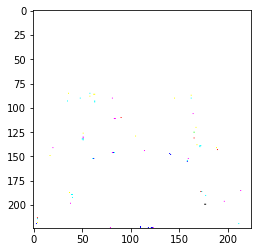

In [11]:
## CLASSIFICATION
transformed_validation_dataset = OpenCVPreprocessor().fit_transform(validation_dataset)
element = next(transformed_validation_dataset.iter_torch_batches(batch_size=1, dtypes=torch.float32))

import matplotlib.pyplot as plt
print(f"CLASS: {ID_CLASS_MAPPING[element['class'].item()]}")
image = np.transpose(element["image"][0], (1, 2, 0))
print(image)
plt.imshow(image)
print(element["image"])
model(element["image"])